In [1]:
import json
import os
import warnings
from pathlib import Path
from typing import Any

import equinox as eqx
import jax.numpy as jnp
import jax.profiler
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from einops import rearrange, repeat
from ipywidgets import interact
from jax import config, device_count, random
from jax.scipy.optimize import minimize
from numpyencoder import NumpyEncoder
from scipy import constants
from stamox.sample import bootstrap

from jackpot.algorithms import AlgorithmChoice
from jackpot.algorithms.base import Algorithm
from jackpot.config import Config, JaxPlatform
from jackpot.fitting import SaturatingExponential
from jackpot.models.base import Model
from jackpot.models.ising import IsingModel
from jackpot.modules import AutocorrelationData
from jackpot.primitives.autocorrelate import acf
from jackpot.primitives.utils import beta_to_temp
from jackpot.profile import Stopwatch
from jackpot.state import Measurement, State
from jackpot.typing import RNGKey
from jackpot.utils.map import filter_map
from jackpot.utils.pbar import make_scan
from jackpot.utils.random import EasyKey

%load_ext autoreload
%autoreload 2

In [2]:
PAPERMILL: bool = False
PAPERMILL_INPUT_PATH: str = ""
PAPERMILL_OUTPUT_PATH: str = ""

In [3]:
# base
JAX_PLATFORM: JaxPlatform = JaxPlatform.CPU
DO_PROFILING: bool = False
ENABLE_64_BIT: bool = False
DO_AUTOCORRELATION: bool = False
DO_MEASURE: bool = True
PLOT_STATES: bool = False
CHECK_THERMALISED: bool = True

# experiment
RNG_SEED: int = 0
SPIN: float = 0.5
DIMENSIONS: int = 2
SIZE: int = 32
TOTAL_SAMPLES: int = 384
N_SAMPLES_VECTORISE: int = 2
LOOP_N_TEMPS_Y: bool = False


# environment
INTERACTION_BILINEAR: float = 1.0
INTERACTION_BIQUADRATIC: float = 0.0
INTERACTION_ANISOTROPY: float = 0.0
INTERACTION_BICUBIC: float = 0.0
INTERACTION_EXTERNAL_FIELD: float = 0.0
NUCLEAR_MAGNETIC_MOMENT: float = 1.0

# environment config
ALGORITHM: AlgorithmChoice = AlgorithmChoice.METROPOLIS_HASTINGS
PROBABILISTIC_CLUSTER_ACCEPT: bool = False

# temperatures
TEMP_MIN: float = 0.80
TEMP_MAX: float = 1.90
N_TEMPS: int = 96

# thermalisation
THERMALISE_STEPS: int = 50
THERMALISE_SWEEPS_PER_STEP: int = 50

# autocorrelation
AUTOCORRELATION_STEPS: int = 1000
AUTOCORRELATION_SWEEPS_PER_STEP: int = 2

# measure
MEASURE_EQUILIBRIUM_STEPS: int = 100
MEASURE_EQUILIBRIUM_NUM: int = 10
MEASURE_EQUILIBRIUM_SWEEPS_PER_STEP: int = 5

In [4]:
# Parameters
PAPERMILL_INPUT_PATH = "workbench.ipynb"
PAPERMILL_OUTPUT_PATH = "experiments/measure_3D/N56_wolff/experiment.ipynb"
PAPERMILL = True
RNG_SEED = 1
JAX_PLATFORM = "tpu"
ALGORITHM = "wolff"
DIMENSIONS = 3
SPIN = 0.5
TOTAL_SAMPLES = 256
N_TEMPS = 16
N_SAMPLES_VECTORISE = 16
THERMALISE_STEPS = 100
THERMALISE_SWEEPS_PER_STEP = 100
TEMP_MIN = 2.25
TEMP_MAX = 2.26
CHECK_THERMALISED = True
DO_AUTOCORRELATION = False
DO_MEASURE = True
MEASURE_EQUILIBRIUM_NUM = 1
MEASURE_EQUILIBRIUM_STEPS = 1000
MEASURE_EQUILIBRIUM_SWEEPS_PER_STEP = 10
PLOT_STATES = False
SIZE = 56


In [5]:
if not PAPERMILL:
    RNG_SEED = 1
    JAX_PLATFORM = "tpu"
    ALGORITHM = "wolff"
    DIMENSIONS = 3
    SPIN = 0.5
    TOTAL_SAMPLES = 64
    N_TEMPS = 32
    N_SAMPLES_VECTORISE = 2
    THERMALISE_STEPS = 100
    THERMALISE_SWEEPS_PER_STEP = 50
    TEMP_MIN = 2.2
    TEMP_MAX = 2.4
    DO_AUTOCORRELATION = False
    DO_MEASURE = True
    SIZE = 32

In [6]:
# Post init
if PAPERMILL:
    from tqdm.std import tqdm
else:
    from tqdm.notebook import tqdm

if PAPERMILL_OUTPUT_PATH:
    SAVE_PATH = Path(PAPERMILL_OUTPUT_PATH).parent.resolve()
else:
    SAVE_PATH = (Path() / "experiments" / "last").resolve()
to_save: dict[str, Any] = {}

print(f"{SAVE_PATH=}")

_CONFIG_VARS = [
    "JAX_PLATFORM",
    "DO_PROFILING",
    "ENABLE_64_BIT",
    "DO_AUTOCORRELATION",
    "DO_MEASURE",
    "PLOT_STATES",
    "CHECK_THERMALISED",
    "RNG_SEED",
    "SPIN",
    "DIMENSIONS",
    "SIZE",
    "TOTAL_SAMPLES",
    "N_SAMPLES_VECTORISE",
    "LOOP_N_TEMPS_Y",
    "THERMALISE_STEPS",
    "THERMALISE_SWEEPS_PER_STEP",
    "INTERACTION_BILINEAR",
    "INTERACTION_BIQUADRATIC",
    "INTERACTION_ANISOTROPY",
    "INTERACTION_BICUBIC",
    "INTERACTION_EXTERNAL_FIELD",
    "NUCLEAR_MAGNETIC_MOMENT",
    "ALGORITHM",
    "PROBABILISTIC_CLUSTER_ACCEPT",
    "TEMP_MIN",
    "TEMP_MAX",
    "N_TEMPS",
    "AUTOCORRELATION_STEPS",
    "AUTOCORRELATION_SWEEPS_PER_STEP",
    "MEASURE_EQUILIBRIUM_STEPS",
    "MEASURE_EQUILIBRIUM_NUM",
    "MEASURE_EQUILIBRIUM_SWEEPS_PER_STEP",
]

_CONFIG_DICT = {}

for var in _CONFIG_VARS:
    _CONFIG_DICT[var.lower()] = globals()[var]
    del globals()[var]

c = Config(**_CONFIG_DICT)

with open(SAVE_PATH / "config.json", "w") as f:
    f.write(c.json(indent=4))


# ---
match c.jax_platform:
    case JaxPlatform.CPU:
        config.update("jax_platform_name", "cpu")
        config.update("jax_platforms", "cpu")

        # CPU cores as separate devices
        os.environ[
            "XLA_FLAGS"
        ] = f"--xla_force_host_platform_device_count={os.cpu_count()}"

    case JaxPlatform.TPU:
        config.update("jax_platform_name", "tpu")
        config.update("jax_platforms", "tpu")

        from jax.experimental.compilation_cache import compilation_cache

        compilation_cache.initialize_cache("/tmp/xla_comp_cache")

        # SEE: https://github.com/google/jax/discussions/12001#discussioncomment-3467948
        os.environ["LIBTPU_INIT_ARGS"] = "--xla_tpu_spmd_rng_bit_generator_unsafe=1"
        config.update("jax_default_prng_impl", "unsafe_rbg")

    case JaxPlatform.GPU:
        config.update("jax_platform_name", "gpu")
        config.update("jax_platforms", "gpu")

    case _:
        raise ValueError("Invalid JaxPlatform")

# config.update("jax_check_tracer_leaks", True)
if c.enable_64_bit:
    config.update("jax_enable_x64", True)

matplotlib.rcParams["figure.figsize"] = (10, 10)

if "_PROFILER_IS_RUNNING" not in globals() and c.do_profiling:
    _PROFILER_IS_RUNNING = True
    jax.profiler.start_server(9999)

Initialized persistent compilation cache at /tmp/xla_comp_cache


SAVE_PATH=PosixPath('/home/jeppe/JaxIsingModel/experiments/measure_3D/N56_wolff')


In [7]:
# Init

DEVICE_COUNT = device_count()
to_save["DEVICE_COUNT"] = DEVICE_COUNT
rng_seed = c.rng_seed if c.rng_seed is not None else np.random.randint(0, 10**10)
to_save["rng_seed"] = rng_seed
k = EasyKey(rng_seed)
rng_key = k.new

MODEL_BASE_PARAMS = {
    "interaction_bilinear": c.interaction_bilinear,
    "interaction_biquadratic": c.interaction_biquadratic,
    "interaction_anisotropy": c.interaction_anisotropy,
    "interaction_bicubic": c.interaction_bicubic,
    "interaction_external_field": c.interaction_external_field,
    "nuclear_magnetic_moment": c.nuclear_magnetic_moment,
    # "probabilistic_cluster_accept": c.probabilistic_cluster_accept,
}

if c.n_temps < DEVICE_COUNT:
    warnings.warn(
        f"Should have at least {DEVICE_COUNT} temperatures for maximum throughput"
    )
N_TEMPS_X = DEVICE_COUNT if DEVICE_COUNT < c.n_temps else c.n_temps
N_TEMPS_Y = c.n_temps // N_TEMPS_X
to_save["N_TEMPS_X"] = N_TEMPS_X
to_save["N_TEMPS_Y"] = N_TEMPS_Y

if not N_TEMPS_X * N_TEMPS_Y == c.n_temps:
    raise ValueError(f"Temperatures should be a multiple of {DEVICE_COUNT}")

N_SAMPLES_PER_TEMP = c.total_samples // (N_TEMPS_X * N_TEMPS_Y)
N_SAMPLES_LOOP = N_SAMPLES_PER_TEMP // c.n_samples_vectorise
to_save["N_SAMPLES_PER_TEMP"] = N_SAMPLES_PER_TEMP
to_save["N_SAMPLES_LOOP"] = N_SAMPLES_LOOP

VECTORISATION_SHAPE = (N_SAMPLES_LOOP, N_TEMPS_X, N_TEMPS_Y, c.n_samples_vectorise)

print(f"Temperatures: {c.n_temps:_}")
print(f"{c.n_temps=}")
print(f"{N_TEMPS_X=}")
print(f"{N_TEMPS_Y=}")
print(f"{N_SAMPLES_PER_TEMP=}")
print(f"--{c.n_samples_vectorise=}")
print(f"--{N_SAMPLES_LOOP=}")

if not N_SAMPLES_LOOP * c.n_samples_vectorise == N_SAMPLES_PER_TEMP:
    raise ValueError(
        "Failed to factorise in a good way. " f"Factors: {VECTORISATION_SHAPE}"
    )
to_save["VECTORISATION_SHAPE"] = VECTORISATION_SHAPE

VECTORISED_COUNT = np.prod(VECTORISATION_SHAPE)
to_save["VECTORISED_COUNT"] = VECTORISED_COUNT
print(f"Vectorised count: {VECTORISED_COUNT:_}")

if not VECTORISED_COUNT == c.total_samples:
    raise ValueError(
        f"Got bad vectorised count: {VECTORISED_COUNT=} != {c.total_samples=}"
    )

TOTAL_SWEEPS = VECTORISED_COUNT * c.thermalise_sweeps_per_step * c.thermalise_steps
to_save["TOTAL_SWEEPS"] = TOTAL_SWEEPS
print(f"Total sweeps: {TOTAL_SWEEPS:_}")

temperatures = np.linspace(c.temp_min, c.temp_max, c.n_temps)
betas = 1.0 / temperatures

match c.algorithm:
    case AlgorithmChoice.WOLFF | AlgorithmChoice.SWENDSEN_WANG:
        algorithm = c.algorithm.resolve()(
            probabilistic_cluster_accept=c.probabilistic_cluster_accept
        )
    case _:
        algorithm = c.algorithm.resolve()()


def transforms(in_axes, out_axes=0):
    def inner(fun):
        # SAMPLES_VECTORISE
        fun = eqx.filter_vmap(fun, in_axes=in_axes, out_axes=out_axes)

        # TEMP_Y
        if c.loop_n_temps_y:
            fun = filter_map(fun)
        else:
            fun = eqx.filter_vmap(fun, in_axes=in_axes, out_axes=out_axes)

        # TEMP_X
        fun = eqx.filter_pmap(fun, in_axes=in_axes, out_axes=out_axes)

        # SAMPLES_LOOP
        fun = filter_map(fun)

        fun = eqx.filter_jit(fun)

        return fun

    return inner


def calculate_known_total(steps: int) -> int:
    total = steps
    total *= N_SAMPLES_LOOP
    total *= N_TEMPS_X

    if c.loop_n_temps_y:
        total *= N_TEMPS_Y

    return total

Temperatures: 16
c.n_temps=16
N_TEMPS_X=8
N_TEMPS_Y=2
N_SAMPLES_PER_TEMP=16
--c.n_samples_vectorise=16
--N_SAMPLES_LOOP=1
Vectorised count: 256
Total sweeps: 2_560_000


In [8]:
# Single state
if not PAPERMILL:
    model = IsingModel.new(spin=c.spin, **MODEL_BASE_PARAMS)
    state = State.new_uniform_random(
        rng_key=k.new,
        dimensions=c.dimensions,
        size=c.size,
        beta=1.0,
        model=model,
        algorithm=algorithm,
        id_=0,
    )

    initial_state = state

    state = state.evolve_sweeps(rng_key=k.new, sweeps=1)
    measured = state.measure()

    state.calculate_energy()
    state.calculate_magnetisation_density()

# Thermalisation

In [9]:
@transforms(in_axes=(0, None, None, 0, 0, None, None, None, None, None))
def make_and_thermalise_states(
    rng_key: RNGKey,
    dimensions: int,
    size: int,
    beta: float,
    id_: int,
    steps: int,
    sweeps_per_step: int,
    model: Model,
    algorithm: Algorithm,
    num_prints: int = 10,
) -> tuple[State, Measurement]:
    """
    Constructs states and thermalises them, returning measurements along the
    way in addition to the thermalised states.

    Arguments:
        rng_key: Source of randomness,
        dimensions: Dimensionality of the system,
        size: Size of each lattice dimension,
        beta: The inverse temperature,
        id_: An ID of the state,
        steps: Number of steps in which to thermalise the state,
        sweeps_per_step: How many times to perform a algorithm sweep per
            thermalisation step,
        model: Instance of the model to use,
        algorithm: An instance of the algorithm to use,
        num_prints: Number of times to update the progress bar (approximately),
    """
    rng_key, state_key = random.split(key=rng_key, num=2)

    state = State.new_minimal(
        rng_key=state_key,
        dimensions=dimensions,
        size=size,
        beta=beta,
        model=model,
        algorithm=algorithm,
        id_=id_,
    )

    def evolve_and_measure(state: State, x: RNGKey) -> tuple[State, Measurement]:
        _key = x
        state = state.evolve_sweeps(rng_key=_key, sweeps=sweeps_per_step)
        measurement = state.measure()

        return state, measurement

    keys = random.split(rng_key, num=steps)
    scan = make_scan(
        tqdm=tqdm, num_prints=num_prints, known_total=calculate_known_total(steps)
    )
    state, measurements = scan(f=evolve_and_measure, init=state, xs=keys)

    return state, measurements


_betas = rearrange(betas, "(x y) -> x y", x=N_TEMPS_X, y=N_TEMPS_Y)
_betas = repeat(
    _betas,
    "x y -> s_loop x y s_vec",
    s_vec=c.n_samples_vectorise,
    s_loop=N_SAMPLES_LOOP,
)
shape = _betas.shape
print(f"{shape=}")

ids = np.arange(np.prod(shape)).reshape(shape)

# Make state
model = IsingModel.new(
    spin=c.spin,
    **MODEL_BASE_PARAMS,
)

# rng_key: RNGKey
# spin: floatj
# dimensions: int
# size: int
# beta: float
# id_: int
# steps: int
# sweeps_per_step: int
# kwargs: dict[str, Any]
# num_prints: int = 10
state_keys = k.shaped(shape)
thermalise_num_prints = 10

thermalise_compile_timer = Stopwatch.start()
make_and_thermalise_states_compiled = make_and_thermalise_states.lower(
    state_keys,
    c.dimensions,
    c.size,
    _betas,
    ids,
    c.thermalise_steps,
    c.thermalise_sweeps_per_step,
    model,
    algorithm,
    thermalise_num_prints,
).compile()
thermalise_compile_time = thermalise_compile_timer.time()
to_save["thermalise_compile_time"] = thermalise_compile_time
print(f"Compiled thermalisation program in: {thermalise_compile_time} sec.")

thermalise_run_timer = Stopwatch.start()
states, evolve_measurements = make_and_thermalise_states_compiled(
    state_keys,
    c.dimensions,
    c.size,
    _betas,
    ids,
    c.thermalise_steps,
    c.thermalise_sweeps_per_step,
    model,
    algorithm,
    thermalise_num_prints,
)
states.block_until_ready()
thermalise_run_time = thermalise_run_timer.time()
to_save["thermalise_run_time"] = thermalise_run_time
print(f"Ran thermalisation program in: {thermalise_run_time} sec.")

eqx.tree_serialise_leaves(SAVE_PATH / "states.eqx", states)

shape=(1, 8, 2, 16)


/home/jeppe/JaxIsingModel/.venv/lib/python3.11/site-packages/jax/_src/dispatch.py:289: UserWarning: The jitted function make_and_thermalise_states includes a pmap. Using jit-of-pmap can lead to inefficient data movement, as the outer jit does not preserve sharded data representations and instead collects input and output arrays onto a single device. Consider removing the outer jit unless you know what you're doing. See https://github.com/google/jax/issues/2926.
  warnings.warn(


Compiled thermalisation program in: 9.568778991699219 sec.


  0%|                                                                                                                                    | 0/800 [00:00<?, ?it/s]

  2%|██▋                                                                                                                      | 18/800 [08:58<6:30:05, 29.93s/it]

  4%|████▏                                                                                                                    | 28/800 [09:14<3:43:47, 17.39s/it]

  5%|█████▋                                                                                                                   | 38/800 [09:22<2:19:19, 10.97s/it]

  6%|███████▎                                                                                                                 | 48/800 [09:28<1:31:14,  7.28s/it]

  7%|████████▊                                                                                                                | 58/800 [09:38<1:03:40,  5.15s/it]

  8%|██████████▍                                                                                                                | 68/800 [09:38<42:26,  3.48s/it]

 10%|███████████▉                                                                                                               | 78/800 [09:39<28:48,  2.39s/it]

 11%|█████████████▌                                                                                                             | 88/800 [09:44<21:23,  1.80s/it]

 11%|█████████████▌                                                                                                             | 88/800 [10:00<21:23,  1.80s/it]

 12%|██████████████▊                                                                                                          | 98/800 [17:45<3:08:09, 16.08s/it]

 14%|████████████████▏                                                                                                       | 108/800 [18:23<2:22:06, 12.32s/it]

 15%|█████████████████▋                                                                                                      | 118/800 [18:36<1:42:00,  8.97s/it]

 16%|███████████████████▏                                                                                                    | 128/800 [19:11<1:21:51,  7.31s/it]

 17%|█████████████████████                                                                                                     | 138/800 [19:12<56:49,  5.15s/it]

 18%|██████████████████████▌                                                                                                   | 148/800 [19:21<41:48,  3.85s/it]

 20%|████████████████████████                                                                                                  | 158/800 [19:25<30:02,  2.81s/it]

 21%|█████████████████████████▌                                                                                                | 168/800 [19:35<24:08,  2.29s/it]

 22%|██████████████████████████▋                                                                                             | 178/800 [26:32<2:26:13, 14.11s/it]

 24%|████████████████████████████▏                                                                                           | 188/800 [27:47<2:03:41, 12.13s/it]

 25%|█████████████████████████████▋                                                                                          | 198/800 [27:51<1:26:28,  8.62s/it]

 26%|███████████████████████████████▏                                                                                        | 208/800 [28:50<1:16:58,  7.80s/it]

 27%|█████████████████████████████████▏                                                                                        | 218/800 [28:53<53:40,  5.53s/it]

 28%|██████████████████████████████████▊                                                                                       | 228/800 [29:10<41:52,  4.39s/it]

 30%|████████████████████████████████████▎                                                                                     | 238/800 [29:13<29:46,  3.18s/it]

 31%|█████████████████████████████████████▊                                                                                    | 248/800 [29:25<23:35,  2.56s/it]

 32%|██████████████████████████████████████▋                                                                                 | 258/800 [35:23<1:53:16, 12.54s/it]

 34%|████████████████████████████████████████▏                                                                               | 268/800 [37:09<1:46:11, 11.98s/it]

 35%|█████████████████████████████████████████▋                                                                              | 278/800 [37:15<1:14:24,  8.55s/it]

 36%|███████████████████████████████████████████▏                                                                            | 288/800 [38:23<1:08:34,  8.04s/it]

 37%|█████████████████████████████████████████████▍                                                                            | 298/800 [38:33<49:27,  5.91s/it]

 38%|██████████████████████████████████████████████▉                                                                           | 308/800 [38:50<38:06,  4.65s/it]

 40%|████████████████████████████████████████████████▍                                                                         | 318/800 [39:01<28:50,  3.59s/it]

 41%|██████████████████████████████████████████████████                                                                        | 328/800 [39:17<23:37,  3.00s/it]

 42%|██████████████████████████████████████████████████▋                                                                     | 338/800 [44:12<1:24:17, 10.95s/it]

 44%|████████████████████████████████████████████████████▏                                                                   | 348/800 [46:35<1:30:03, 11.95s/it]

 45%|█████████████████████████████████████████████████████▋                                                                  | 358/800 [46:36<1:01:49,  8.39s/it]

 46%|████████████████████████████████████████████████████████                                                                  | 368/800 [47:54<59:08,  8.21s/it]

 47%|█████████████████████████████████████████████████████████▋                                                                | 378/800 [48:14<44:42,  6.36s/it]

 48%|███████████████████████████████████████████████████████████▏                                                              | 388/800 [48:36<34:57,  5.09s/it]

 50%|████████████████████████████████████████████████████████████▋                                                             | 398/800 [48:45<25:46,  3.85s/it]

 51%|██████████████████████████████████████████████████████████████▏                                                           | 408/800 [49:12<22:52,  3.50s/it]

 52%|██████████████████████████████████████████████████████████████▋                                                         | 418/800 [53:10<1:01:07,  9.60s/it]

 54%|████████████████████████████████████████████████████████████████▏                                                       | 428/800 [55:54<1:12:08, 11.64s/it]

 55%|██████████████████████████████████████████████████████████████████▊                                                       | 438/800 [55:57<49:39,  8.23s/it]

 56%|████████████████████████████████████████████████████████████████████▎                                                     | 448/800 [57:30<50:12,  8.56s/it]

 57%|█████████████████████████████████████████████████████████████████████▊                                                    | 458/800 [57:50<37:31,  6.58s/it]

 58%|███████████████████████████████████████████████████████████████████████▎                                                  | 468/800 [58:23<30:58,  5.60s/it]

 60%|████████████████████████████████████████████████████████████████████████▉                                                 | 478/800 [58:26<21:30,  4.01s/it]

 61%|██████████████████████████████████████████████████████████████████████████▍                                               | 488/800 [59:05<20:42,  3.98s/it]

 62%|██████████████████████████████████████████████████████████████████████████▋                                             | 498/800 [1:02:20<43:23,  8.62s/it]

 64%|████████████████████████████████████████████████████████████████████████████▏                                           | 508/800 [1:04:58<52:29, 10.79s/it]

 65%|█████████████████████████████████████████████████████████████████████████████▋                                          | 518/800 [1:05:19<38:25,  8.17s/it]

 66%|███████████████████████████████████████████████████████████████████████████████▏                                        | 528/800 [1:06:59<39:31,  8.72s/it]

 67%|████████████████████████████████████████████████████████████████████████████████▋                                       | 538/800 [1:07:31<30:50,  7.06s/it]

 68%|██████████████████████████████████████████████████████████████████████████████████▏                                     | 548/800 [1:08:10<25:39,  6.11s/it]

 70%|███████████████████████████████████████████████████████████████████████████████████▋                                    | 558/800 [1:08:16<18:00,  4.47s/it]

 71%|█████████████████████████████████████████████████████████████████████████████████████▏                                  | 568/800 [1:08:55<16:39,  4.31s/it]

 72%|██████████████████████████████████████████████████████████████████████████████████████▋                                 | 578/800 [1:11:07<25:44,  6.96s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████████▏                               | 588/800 [1:14:13<36:56, 10.46s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████▋                              | 598/800 [1:14:44<27:45,  8.25s/it]

 76%|███████████████████████████████████████████████████████████████████████████████████████████▏                            | 608/800 [1:16:36<29:13,  9.13s/it]

 77%|████████████████████████████████████████████████████████████████████████████████████████████▋                           | 618/800 [1:17:03<21:52,  7.21s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████▏                         | 628/800 [1:18:02<19:32,  6.81s/it]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████▋                        | 638/800 [1:18:09<13:24,  4.97s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 648/800 [1:18:48<11:47,  4.66s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 658/800 [1:19:54<12:26,  5.26s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████                    | 667/800 [1:20:48<12:05,  5.46s/it]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 677/800 [1:23:38<18:23,  8.97s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████                 | 687/800 [1:24:01<13:06,  6.96s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 696/800 [1:24:33<10:23,  6.00s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 705/800 [1:24:56<07:56,  5.02s/it]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 715/800 [1:26:22<08:39,  6.12s/it]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 725/800 [1:26:41<06:01,  4.83s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 734/800 [1:27:19<05:07,  4.65s/it]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 743/800 [1:27:39<03:45,  3.95s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 753/800 [1:27:48<02:20,  2.98s/it]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 763/800 [1:27:54<01:23,  2.26s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 773/800 [1:28:44<01:23,  3.10s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 782/800 [1:28:47<00:41,  2.30s/it]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 791/800 [1:28:53<00:16,  1.86s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [1:29:46<00:00,  3.01s/it]

Ran thermalisation program in: 5918.890108823776 sec.


In [10]:
_evolve_meas_df = evolve_measurements.to_df()
evolve_meas_df = _evolve_meas_df.explode(
    _evolve_meas_df.columns.tolist()
).infer_objects()

evolve_meas_df["temp"] = beta_to_temp(evolve_meas_df["beta"], human=True)
evolve_meas_df["abs_magnetisation_density"] = np.abs(
    evolve_meas_df["magnetisation_density"]
)

In [11]:
# Get only last measurements
last_meas_df = (
    evolve_meas_df.sort_values("sweeps", ascending=False).groupby("state_id").first()
)
n_steps = last_meas_df["steps"].sum()

flip_rate = n_steps / (thermalise_run_time * 1e6)  # flips / μs
to_save["flip_rate"] = flip_rate
print(f"Flip rate: {flip_rate} flips/μs")

Flip rate: 2.360020295388777 flips/μs


In [12]:
evolve_meas_df.reset_index().to_feather(SAVE_PATH / "evolve_meas_df.feather")

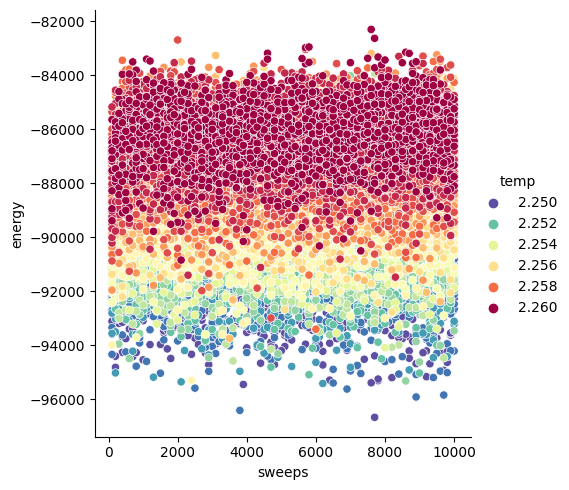

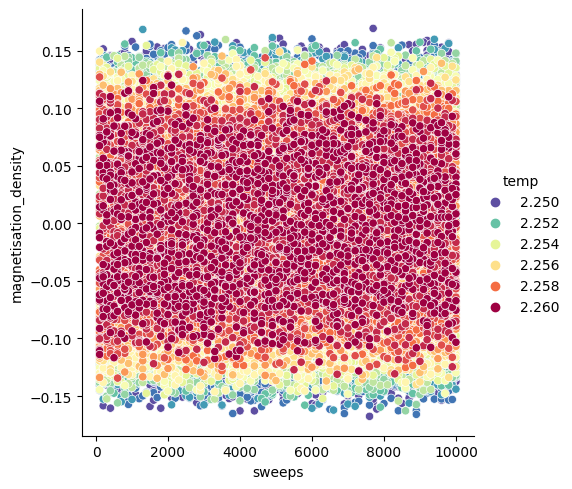

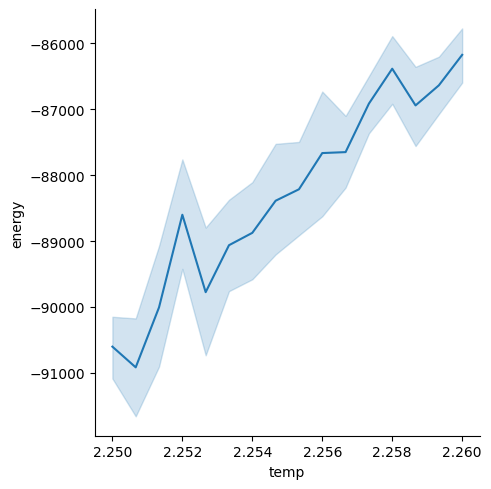

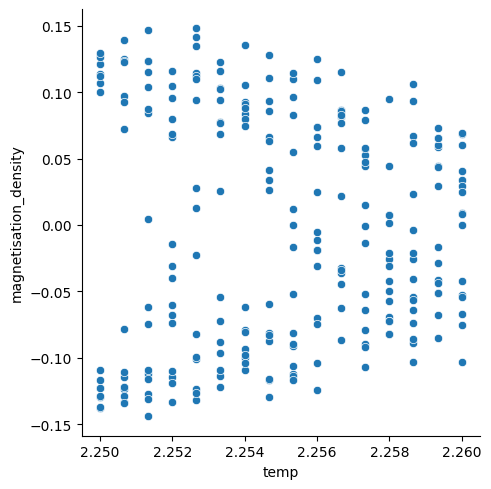

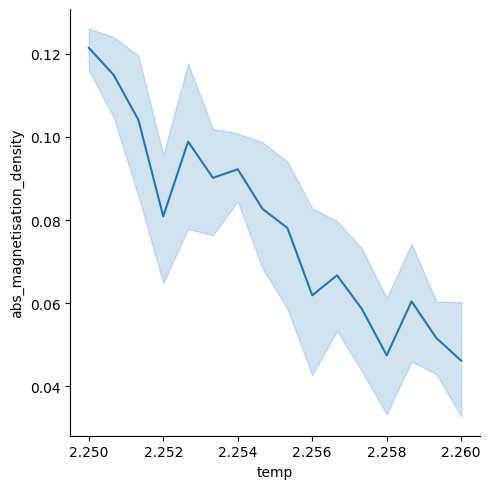

In [13]:
fig_evolve_energy_sweeps = sns.relplot(
    data=evolve_meas_df,
    x="sweeps",
    y="energy",
    hue="temp",
    palette="Spectral_r",
)
fig_evolve_energy_sweeps.savefig(SAVE_PATH / "fig_evolve_energy_sweeps.png")

fig_evolve_mag_dens_sweeps = sns.relplot(
    data=evolve_meas_df,
    x="sweeps",
    y="magnetisation_density",
    hue="temp",
    palette="Spectral_r",
)
fig_evolve_mag_dens_sweeps.savefig(SAVE_PATH / "fig_evolve_mag_dens_sweeps.png")

last_sweeps = evolve_meas_df[
    evolve_meas_df["sweeps"] == np.max(evolve_meas_df["sweeps"])
]

fig_evolve_energy_temp = sns.relplot(
    data=last_sweeps,
    x="temp",
    y="energy",
    # hue="beta",
    kind="line",
    # errorbar=None
)
fig_evolve_energy_temp.savefig(SAVE_PATH / "fig_evolve_energy_temp.png")

fig_evolve_mag_dens_temp = sns.relplot(
    data=last_sweeps,
    x="temp",
    y="magnetisation_density",
)
fig_evolve_mag_dens_temp.savefig(SAVE_PATH / "fig_evolve_mag_dens_temp.png")

fig_evolve_abs_mag_dens_temp = sns.relplot(
    data=last_sweeps,
    x="temp",
    y="abs_magnetisation_density",
    kind="line",
    # errorbar=None
)
fig_evolve_abs_mag_dens_temp.savefig(SAVE_PATH / "fig_evolve_abs_mag_dens_temp.png")

In [14]:
if c.plot_states:
    states_list = states.unensamble()
    temp_states = states_list[: c.n_temps]

In [15]:
if c.plot_states:

    @interact(value=0, min=0, max=len(temp_states))
    def update(i=(0, len(temp_states) - 1)):
        fig = temp_states[i].plot()
        fig.set_size_inches(10, 10)
        fig.dpi = 100

    ...

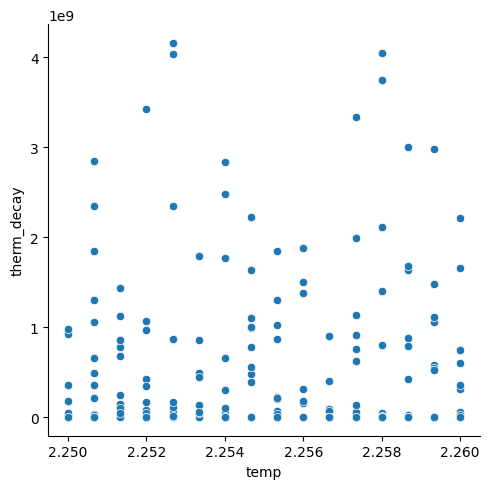

In [16]:
if c.check_thermalised:
    # Fit saturating decay times to quantifiably understand whether we have fully thermalised
    def fit_thermalisation(group):
        x = group["sweeps"]
        y = group["energy"]

        amplitude = np.max(y) - np.min(y)
        decay = np.max(x)
        offset = y.iloc[-1]

        params = SaturatingExponential.make_params()
        params["amplitude"].set(amplitude)
        params["decay"].set(decay, min=0, max=np.inf)
        params["c"].set(offset)

        fit = SaturatingExponential.fit(y, params, x=x)

        assert np.ptp(group["temp"]) == 0.0

        return pd.Series(
            {
                "temp": group["temp"].iloc[0],
                "therm_amplitude": fit.params["amplitude"].value,
                "therm_amplitude_sd": fit.params["amplitude"].stderr,
                "therm_decay": fit.params["decay"].value,
                "therm_decay_sd": fit.params["decay"].stderr,
                "therm_offset": fit.params["c"].value,
                "therm_offset_sd": fit.params["c"].stderr,
            }
        )

    evolve_meas_fit_df = evolve_meas_df.groupby("state_id", as_index=False).apply(
        fit_thermalisation
    )
    fig_evolve_therm_fit = sns.relplot(
        data=evolve_meas_fit_df,
        x="temp",
        y="therm_decay",
    )
    fig_evolve_therm_fit.savefig(SAVE_PATH / "fig_evolve_therm_fit.png")

    def _has_thermalised():
        high_temp_df = evolve_meas_fit_df[
            evolve_meas_fit_df["temp"] == evolve_meas_fit_df["temp"].max()
        ]
        therm_check_df = high_temp_df[
            high_temp_df["therm_decay"] > 4.0 * high_temp_df["therm_decay_sd"]
        ]

        # We have no data to check probably because system is very very thermalised
        # and thus has no data to fit to exponential
        if not len(therm_check_df):
            return True

        longest_decay = therm_check_df["therm_decay"].max()
        print(longest_decay)
        if evolve_meas_df["sweeps"].max() > 6.0 * longest_decay:
            return True

        return False

    has_thermalised = _has_thermalised()

    if not has_thermalised:
        raise RuntimeError("System has not fully thermalised!")

# Autocorrelation

In [17]:
if c.do_autocorrelation:

    @transforms(in_axes=(0, 0, None, None, None), out_axes=0)
    def get_autocorrelation(
        key: RNGKey, state: State, steps: int, sweeps_per_step: int, num_prints: int
    ) -> AutocorrelationData:
        keys = random.split(key, num=steps)

        def get_measurement_scan(state: State, x: RNGKey) -> tuple[State, Measurement]:
            rng_key = x
            state = state.evolve_sweeps(rng_key=rng_key, sweeps=sweeps_per_step)
            measurement = state.measure()

            return state, measurement

        scan = make_scan(
            tqdm=tqdm, num_prints=num_prints, known_total=calculate_known_total(steps)
        )
        state, measurements = scan(f=get_measurement_scan, init=state, xs=keys)

        acorr_energy = acf(measurements.energy)
        acorr_mag_dens = acf(jnp.abs(measurements.magnetisation_density))

        sweeps = jnp.arange(acorr_energy.size) * sweeps_per_step

        # Fit exponential decay to find characteristic autocorrelation time
        def exponential_decay(x, tau):
            """
            f(x) = exp(- x / τ)
            """
            return jnp.exp(-x / tau)

        # Objective function to minimise
        def objective(params, x, y, weights):
            tau = params
            trial = exponential_decay(x, tau)
            residuals = y - trial
            weighted_residuals = weights * residuals

            return jnp.sum(weighted_residuals**2)

        energy_initial_params = jnp.asarray([float(sweeps_per_step)])
        # Noise at high x (low y) dominates fit.
        # Weigh by ordinate magnitude
        energy_weights = jnp.abs(acorr_energy)
        energy_decay_time = minimize(
            objective,
            x0=energy_initial_params,
            method="BFGS",
            args=(sweeps, acorr_energy, energy_weights),
        ).x[0]

        mag_dens_initial_params = jnp.asarray([float(sweeps_per_step)])
        mag_dens_weights = jnp.abs(acorr_mag_dens)
        mag_dens_decay_time = minimize(
            objective,
            x0=mag_dens_initial_params,
            method="BFGS",
            args=(sweeps, acorr_mag_dens, mag_dens_weights),
        ).x[0]

        return AutocorrelationData(
            state=state,
            steps=steps,
            sweeps_per_step=sweeps_per_step,
            sweeps=sweeps,
            energy=acorr_energy,
            magnetisation_density=acorr_mag_dens,
            energy_decay_time=energy_decay_time,
            magnetisation_density_decay_time=mag_dens_decay_time,
        )

    keys = k.shaped(states.transformation_shape)

    autocorrelation_timer = Stopwatch.start()
    ac_data = get_autocorrelation(
        keys, states, c.autocorrelation_steps, c.autocorrelation_sweeps_per_step, 10
    )
    ac_data.block_until_ready()

    autocorrelation_time = autocorrelation_timer.time()
    to_save["autocorrelation_time"] = autocorrelation_time
    print(f"Ran autocorrelation program in: {autocorrelation_time} sec.")

    eqx.tree_serialise_leaves(SAVE_PATH / "ac_data.eqx", ac_data)

In [18]:
if c.do_autocorrelation:
    ac_df = ac_data.to_df()
    ac_df["temp"] = beta_to_temp(ac_df["state.beta"], human=True)
    ac_df_expl = ac_df.explode(
        ["energy", "magnetisation_density", "sweeps"]
    ).infer_objects()

    ac_df_expl["energy_fit"] = np.exp(
        -ac_df_expl["sweeps"] / ac_df_expl["energy_decay_time"]
    )
    ac_df_expl["mag_dens_fit"] = np.exp(
        -ac_df_expl["sweeps"] / ac_df_expl["magnetisation_density_decay_time"]
    )

    display(ac_df)
    display(ac_df_expl)

    ac_df.reset_index().to_feather(SAVE_PATH / "ac_df.feather")
    ac_df_expl.reset_index().to_feather(SAVE_PATH / "ac_df_expl.feather")

In [19]:
if c.do_autocorrelation:
    fig_autocorrelation_energy = plt.figure()
    sns.lineplot(
        data=ac_df_expl,
        x="sweeps",
        y="energy",
        hue="temp",
        palette="Spectral_r",
        errorbar=None,
    )
    sns.lineplot(
        data=ac_df_expl,
        x="sweeps",
        y="energy_fit",
        hue="temp",
        palette="Spectral_r",
        ls="--",
        errorbar=None,
    )
    fig_autocorrelation_energy.savefig(SAVE_PATH / "fig_autocorrelation_energy.png")

    fig_autocorrelation_mag_dens = plt.figure()
    sns.lineplot(
        data=ac_df_expl,
        x="sweeps",
        y="magnetisation_density",
        hue="temp",
        palette="Spectral_r",
        errorbar=None,
    )
    sns.lineplot(
        data=ac_df_expl,
        x="sweeps",
        y="mag_dens_fit",
        hue="temp",
        palette="Spectral_r",
        ls="--",
        errorbar=None,
    )
    fig_autocorrelation_mag_dens.savefig(SAVE_PATH / "fig_autocorrelation_mag_dens.png")

    fig_autocorrelation_decay_times, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    sns.lineplot(
        data=ac_df,
        x="temp",
        y="energy_decay_time",
        ax=ax1,
    )
    sns.lineplot(
        data=ac_df,
        x="temp",
        y="magnetisation_density_decay_time",
        ax=ax2,
        color="orange",
    )
    plt.show()
    fig_autocorrelation_decay_times.savefig(
        SAVE_PATH / "fig_autocorrelation_decay_times.png"
    )

# Measure Equilibrium

In [20]:
if c.do_measure:

    @transforms(in_axes=(0, 0, None, None, None, None), out_axes=0)
    def measure_equilibrium(
        key: RNGKey, state: State, steps: int, num: int, sweeps: int, num_prints: int
    ) -> Measurement:
        def body_fun(carry: State, x: RNGKey):
            _rng_key = x
            measurements = carry.evolve_and_measure_multiple(
                rng_key=_rng_key, num=num, sweeps=sweeps
            )

            return carry, measurements

        keys = random.split(key=key, num=steps)
        scan = make_scan(
            tqdm=tqdm, num_prints=num_prints, known_total=calculate_known_total(steps)
        )
        state, measurements = scan(f=body_fun, init=state, xs=keys)

        return measurements

    keys = k.shaped(states.transformation_shape)

    measurement_timer = Stopwatch.start()
    equil_measurements = measure_equilibrium(
        keys,
        states,
        c.measure_equilibrium_steps,
        c.measure_equilibrium_num,
        c.measure_equilibrium_sweeps_per_step,
        100,
    )
    equil_measurements.block_until_ready()

    measurement_time = measurement_timer.time()
    to_save["measurement_time"] = measurement_time
    print(f"Ran measurement program in: {measurement_time} sec.")

    eqx.tree_serialise_leaves(SAVE_PATH / "equil_measurements.eqx", equil_measurements)

/home/jeppe/JaxIsingModel/.venv/lib/python3.11/site-packages/jax/_src/dispatch.py:289: UserWarning: The jitted function measure_equilibrium includes a pmap. Using jit-of-pmap can lead to inefficient data movement, as the outer jit does not preserve sharded data representations and instead collects input and output arrays onto a single device. Consider removing the outer jit unless you know what you're doing. See https://github.com/google/jax/issues/2926.
  warnings.warn(


  0%|                                                                                                                                   | 0/8000 [00:00<?, ?it/s]

  0%|▎                                                                                                                       | 18/8000 [00:54<6:43:02,  3.03s/it]

  0%|▍                                                                                                                       | 28/8000 [00:54<3:46:24,  1.70s/it]

  0%|▌                                                                                                                       | 38/8000 [00:55<2:22:01,  1.07s/it]

  1%|▋                                                                                                                       | 48/8000 [00:56<1:37:55,  1.35it/s]

  1%|▊                                                                                                                       | 58/8000 [00:57<1:09:05,  1.92it/s]

  1%|█                                                                                                                         | 68/8000 [00:58<47:44,  2.77it/s]

  1%|█▏                                                                                                                        | 78/8000 [00:58<34:27,  3.83it/s]

  1%|█▎                                                                                                                        | 88/8000 [00:59<25:37,  5.14it/s]

  1%|█▎                                                                                                                        | 88/8000 [01:09<25:37,  5.14it/s]

  1%|█▍                                                                                                                      | 98/8000 [01:50<3:46:26,  1.72s/it]

  1%|█▌                                                                                                                     | 108/8000 [01:53<2:47:34,  1.27s/it]

  1%|█▊                                                                                                                     | 118/8000 [01:53<1:58:34,  1.11it/s]

  2%|█▉                                                                                                                     | 128/8000 [01:53<1:23:33,  1.57it/s]

  2%|██                                                                                                                       | 138/8000 [01:54<59:16,  2.21it/s]

  2%|██▏                                                                                                                      | 148/8000 [01:54<43:51,  2.98it/s]

  2%|██▍                                                                                                                      | 158/8000 [01:57<41:15,  3.17it/s]

  2%|██▌                                                                                                                      | 168/8000 [01:59<37:19,  3.50it/s]

  2%|██▌                                                                                                                      | 168/8000 [02:19<37:19,  3.50it/s]

  2%|██▋                                                                                                                    | 178/8000 [02:47<3:32:18,  1.63s/it]

  2%|██▊                                                                                                                    | 188/8000 [02:49<2:36:48,  1.20s/it]

  2%|██▉                                                                                                                    | 198/8000 [02:50<1:54:24,  1.14it/s]

  3%|███                                                                                                                    | 208/8000 [02:51<1:23:15,  1.56it/s]

  3%|███▎                                                                                                                     | 218/8000 [02:51<59:38,  2.17it/s]

  3%|███▍                                                                                                                     | 228/8000 [02:53<48:36,  2.66it/s]

  3%|███▌                                                                                                                     | 238/8000 [02:56<43:36,  2.97it/s]

  3%|███▊                                                                                                                     | 248/8000 [03:00<48:57,  2.64it/s]

  3%|███▊                                                                                                                   | 258/8000 [03:41<3:10:43,  1.48s/it]

  3%|███▉                                                                                                                   | 268/8000 [03:46<2:32:50,  1.19s/it]

  3%|████▏                                                                                                                  | 278/8000 [03:46<1:48:12,  1.19it/s]

  4%|████▎                                                                                                                  | 288/8000 [03:48<1:20:45,  1.59it/s]

  4%|████▍                                                                                                                  | 298/8000 [03:50<1:05:49,  1.95it/s]

  4%|████▋                                                                                                                    | 308/8000 [03:52<52:36,  2.44it/s]

  4%|████▊                                                                                                                    | 318/8000 [03:55<48:59,  2.61it/s]

  4%|████▉                                                                                                                    | 328/8000 [04:00<52:37,  2.43it/s]

  4%|█████                                                                                                                  | 338/8000 [04:36<2:55:41,  1.38s/it]

  4%|█████▏                                                                                                                 | 348/8000 [04:44<2:33:35,  1.20s/it]

  4%|█████▎                                                                                                                 | 358/8000 [04:45<1:52:06,  1.14it/s]

  5%|█████▍                                                                                                                 | 368/8000 [04:47<1:23:26,  1.52it/s]

  5%|█████▋                                                                                                                   | 378/8000 [04:47<59:09,  2.15it/s]

  5%|█████▊                                                                                                                   | 388/8000 [04:49<50:07,  2.53it/s]

  5%|██████                                                                                                                   | 398/8000 [04:53<50:07,  2.53it/s]

  5%|██████▏                                                                                                                  | 408/8000 [04:59<59:09,  2.14it/s]

  5%|██████▏                                                                                                                | 418/8000 [05:31<2:39:57,  1.27s/it]

  5%|██████▎                                                                                                                | 428/8000 [05:40<2:26:28,  1.16s/it]

  5%|██████▌                                                                                                                | 438/8000 [05:43<1:55:28,  1.09it/s]

  6%|██████▋                                                                                                                | 448/8000 [05:44<1:24:22,  1.49it/s]

  6%|██████▊                                                                                                                | 458/8000 [05:45<1:02:56,  2.00it/s]

  6%|███████                                                                                                                  | 468/8000 [05:49<56:57,  2.20it/s]

  6%|███████▏                                                                                                                 | 478/8000 [05:52<52:35,  2.38it/s]

  6%|███████▎                                                                                                               | 488/8000 [05:59<1:04:10,  1.95it/s]

  6%|███████▍                                                                                                               | 498/8000 [06:25<2:21:10,  1.13s/it]

  6%|███████▌                                                                                                               | 508/8000 [06:36<2:18:08,  1.11s/it]

  6%|███████▋                                                                                                               | 518/8000 [06:40<1:52:16,  1.11it/s]

  7%|███████▊                                                                                                               | 528/8000 [06:42<1:27:13,  1.43it/s]

  7%|████████                                                                                                               | 538/8000 [06:42<1:01:50,  2.01it/s]

  7%|████████▏                                                                                                              | 548/8000 [06:47<1:01:54,  2.01it/s]

  7%|████████▍                                                                                                                | 558/8000 [06:49<50:48,  2.44it/s]

  7%|████████▍                                                                                                              | 568/8000 [06:59<1:12:53,  1.70it/s]

  7%|████████▌                                                                                                              | 578/8000 [07:19<2:02:46,  1.01it/s]

  7%|████████▋                                                                                                              | 588/8000 [07:34<2:22:33,  1.15s/it]

  7%|████████▉                                                                                                              | 598/8000 [07:36<1:47:10,  1.15it/s]

  8%|█████████                                                                                                              | 608/8000 [07:39<1:26:34,  1.42it/s]

  8%|█████████▏                                                                                                             | 618/8000 [07:42<1:10:12,  1.75it/s]

  8%|█████████▎                                                                                                             | 628/8000 [07:45<1:01:42,  1.99it/s]

  8%|█████████▋                                                                                                               | 638/8000 [07:47<48:58,  2.51it/s]

  8%|█████████▋                                                                                                             | 648/8000 [07:59<1:20:01,  1.53it/s]

  8%|█████████▊                                                                                                             | 658/8000 [08:13<1:46:32,  1.15it/s]

  8%|█████████▉                                                                                                             | 668/8000 [08:31<2:18:10,  1.13s/it]

  8%|██████████                                                                                                             | 678/8000 [08:34<1:50:22,  1.11it/s]

  9%|██████████▏                                                                                                            | 688/8000 [08:38<1:29:52,  1.36it/s]

  9%|██████████▍                                                                                                            | 698/8000 [08:41<1:12:48,  1.67it/s]

  9%|██████████▌                                                                                                            | 708/8000 [08:45<1:06:19,  1.83it/s]

  9%|██████████▊                                                                                                              | 718/8000 [08:46<49:26,  2.45it/s]

  9%|██████████▊                                                                                                            | 728/8000 [08:59<1:23:34,  1.45it/s]

  9%|██████████▉                                                                                                            | 738/8000 [09:06<1:23:23,  1.45it/s]

  9%|███████████▏                                                                                                           | 748/8000 [09:26<2:12:06,  1.09s/it]

  9%|███████████▎                                                                                                           | 758/8000 [09:29<1:42:43,  1.18it/s]

 10%|███████████▍                                                                                                           | 768/8000 [09:38<1:44:22,  1.15it/s]

 10%|███████████▌                                                                                                           | 778/8000 [09:39<1:14:36,  1.61it/s]

 10%|███████████▋                                                                                                           | 788/8000 [09:43<1:08:12,  1.76it/s]

 10%|████████████                                                                                                             | 798/8000 [09:44<49:56,  2.40it/s]

 10%|████████████                                                                                                           | 808/8000 [10:00<1:34:25,  1.27it/s]

 10%|████████████▏                                                                                                          | 818/8000 [10:03<1:15:18,  1.59it/s]

 10%|████████████▎                                                                                                          | 828/8000 [10:23<2:04:25,  1.04s/it]

 10%|████████████▍                                                                                                          | 838/8000 [10:27<1:39:59,  1.19it/s]

 11%|████████████▌                                                                                                          | 848/8000 [10:38<1:50:06,  1.08it/s]

 11%|████████████▊                                                                                                          | 858/8000 [10:38<1:19:18,  1.50it/s]

 11%|████████████▉                                                                                                          | 868/8000 [10:41<1:03:45,  1.86it/s]

 11%|█████████████▎                                                                                                           | 878/8000 [10:43<52:34,  2.26it/s]

 11%|█████████████▏                                                                                                         | 888/8000 [10:56<1:24:38,  1.40it/s]

 11%|█████████████▎                                                                                                         | 898/8000 [10:59<1:07:21,  1.76it/s]

 11%|█████████████▌                                                                                                         | 908/8000 [11:19<1:59:57,  1.01s/it]

 11%|█████████████▋                                                                                                         | 918/8000 [11:24<1:39:58,  1.18it/s]

 12%|█████████████▊                                                                                                         | 928/8000 [11:35<1:49:05,  1.08it/s]

 12%|█████████████▉                                                                                                         | 938/8000 [11:36<1:21:23,  1.45it/s]

 12%|██████████████                                                                                                         | 948/8000 [11:40<1:08:08,  1.72it/s]

 12%|██████████████▍                                                                                                          | 958/8000 [11:40<50:32,  2.32it/s]

 12%|██████████████▍                                                                                                        | 968/8000 [11:51<1:13:27,  1.60it/s]

 12%|██████████████▌                                                                                                        | 978/8000 [11:59<1:18:01,  1.50it/s]

 12%|██████████████▋                                                                                                        | 988/8000 [12:15<1:52:06,  1.04it/s]

 12%|██████████████▊                                                                                                        | 998/8000 [12:21<1:38:13,  1.19it/s]

 13%|██████████████▊                                                                                                       | 1008/8000 [12:31<1:42:11,  1.14it/s]

 13%|███████████████                                                                                                       | 1018/8000 [12:34<1:24:37,  1.38it/s]

 13%|███████████████▏                                                                                                      | 1028/8000 [12:37<1:09:47,  1.67it/s]

 13%|███████████████▌                                                                                                        | 1038/8000 [12:39<55:45,  2.08it/s]

 13%|███████████████▍                                                                                                      | 1048/8000 [12:46<1:01:16,  1.89it/s]

 13%|███████████████▌                                                                                                      | 1058/8000 [13:00<1:31:21,  1.27it/s]

 13%|███████████████▊                                                                                                      | 1068/8000 [13:10<1:40:48,  1.15it/s]

 13%|███████████████▉                                                                                                      | 1078/8000 [13:19<1:41:28,  1.14it/s]

 14%|████████████████                                                                                                      | 1088/8000 [13:30<1:47:50,  1.07it/s]

 14%|████████████████▏                                                                                                     | 1098/8000 [13:33<1:26:02,  1.34it/s]

 14%|████████████████▎                                                                                                     | 1108/8000 [13:37<1:13:30,  1.56it/s]

 14%|████████████████▊                                                                                                       | 1118/8000 [13:39<56:40,  2.02it/s]

 14%|████████████████▉                                                                                                       | 1128/8000 [13:39<42:20,  2.70it/s]

 14%|████████████████▊                                                                                                     | 1138/8000 [13:59<1:37:58,  1.17it/s]

 14%|████████████████▉                                                                                                     | 1148/8000 [14:07<1:35:30,  1.20it/s]

 14%|█████████████████                                                                                                     | 1158/8000 [14:16<1:37:18,  1.17it/s]

 15%|█████████████████▏                                                                                                    | 1168/8000 [14:28<1:50:05,  1.03it/s]

 15%|█████████████████▍                                                                                                    | 1178/8000 [14:31<1:23:53,  1.36it/s]

 15%|█████████████████▌                                                                                                    | 1188/8000 [14:33<1:05:53,  1.72it/s]

 15%|█████████████████▉                                                                                                      | 1198/8000 [14:35<55:38,  2.04it/s]

 15%|██████████████████                                                                                                      | 1208/8000 [14:37<44:00,  2.57it/s]

 15%|█████████████████▉                                                                                                    | 1218/8000 [15:00<1:48:12,  1.04it/s]

 15%|██████████████████                                                                                                    | 1228/8000 [15:05<1:33:58,  1.20it/s]

 15%|██████████████████▎                                                                                                   | 1238/8000 [15:12<1:29:50,  1.25it/s]

 16%|██████████████████▍                                                                                                   | 1248/8000 [15:27<1:52:29,  1.00it/s]

 16%|██████████████████▌                                                                                                   | 1258/8000 [15:28<1:20:41,  1.39it/s]

 16%|███████████████████                                                                                                     | 1268/8000 [15:28<57:58,  1.94it/s]

 16%|██████████████████▊                                                                                                   | 1278/8000 [15:35<1:04:03,  1.75it/s]

 16%|███████████████████▏                                                                                                  | 1298/8000 [16:00<1:37:31,  1.15it/s]

 16%|███████████████████▎                                                                                                  | 1308/8000 [16:02<1:19:14,  1.41it/s]

 16%|███████████████████▍                                                                                                  | 1318/8000 [16:10<1:22:15,  1.35it/s]

 17%|███████████████████▌                                                                                                  | 1328/8000 [16:22<1:35:35,  1.16it/s]

 17%|███████████████████▋                                                                                                  | 1338/8000 [16:25<1:17:49,  1.43it/s]

 17%|███████████████████▉                                                                                                  | 1348/8000 [16:26<1:00:57,  1.82it/s]

 17%|████████████████████                                                                                                  | 1358/8000 [16:33<1:04:23,  1.72it/s]

 17%|████████████████████▌                                                                                                   | 1368/8000 [16:35<52:31,  2.10it/s]

 17%|████████████████████▎                                                                                                 | 1378/8000 [16:58<1:50:53,  1.00s/it]

 17%|████████████████████▍                                                                                                 | 1388/8000 [16:59<1:22:47,  1.33it/s]

 17%|████████████████████▌                                                                                                 | 1398/8000 [17:08<1:25:40,  1.28it/s]

 18%|████████████████████▊                                                                                                 | 1408/8000 [17:17<1:28:39,  1.24it/s]

 18%|████████████████████▉                                                                                                 | 1418/8000 [17:24<1:27:39,  1.25it/s]

 18%|█████████████████████                                                                                                 | 1428/8000 [17:26<1:07:30,  1.62it/s]

 18%|█████████████████████▏                                                                                                | 1438/8000 [17:32<1:04:36,  1.69it/s]

 18%|█████████████████████▋                                                                                                  | 1448/8000 [17:36<58:22,  1.87it/s]

 18%|█████████████████████▌                                                                                                | 1458/8000 [17:55<1:43:24,  1.05it/s]

 18%|█████████████████████▋                                                                                                | 1468/8000 [17:57<1:19:31,  1.37it/s]

 18%|█████████████████████▊                                                                                                | 1478/8000 [18:06<1:24:17,  1.29it/s]

 19%|█████████████████████▉                                                                                                | 1488/8000 [18:10<1:11:38,  1.51it/s]

 19%|██████████████████████                                                                                                | 1498/8000 [18:22<1:28:35,  1.22it/s]

 19%|██████████████████████▏                                                                                               | 1508/8000 [18:25<1:11:46,  1.51it/s]

 19%|██████████████████████▍                                                                                               | 1518/8000 [18:30<1:06:52,  1.62it/s]

 19%|██████████████████████▉                                                                                                 | 1528/8000 [18:33<57:29,  1.88it/s]

 19%|██████████████████████▋                                                                                               | 1538/8000 [18:51<1:36:48,  1.11it/s]

 19%|██████████████████████▊                                                                                               | 1548/8000 [18:57<1:27:36,  1.23it/s]

 19%|██████████████████████▉                                                                                               | 1558/8000 [19:03<1:21:00,  1.33it/s]

 20%|███████████████████████▏                                                                                              | 1568/8000 [19:05<1:04:37,  1.66it/s]

 20%|███████████████████████▎                                                                                              | 1578/8000 [19:17<1:23:49,  1.28it/s]

 20%|███████████████████████▍                                                                                              | 1588/8000 [19:23<1:15:57,  1.41it/s]

 20%|███████████████████████▌                                                                                              | 1598/8000 [19:26<1:04:23,  1.66it/s]

 20%|███████████████████████▋                                                                                              | 1608/8000 [19:31<1:00:33,  1.76it/s]

 20%|███████████████████████▊                                                                                              | 1618/8000 [19:46<1:28:51,  1.20it/s]

 20%|████████████████████████                                                                                              | 1628/8000 [19:57<1:37:21,  1.09it/s]

 20%|████████████████████████▏                                                                                             | 1638/8000 [20:00<1:18:50,  1.34it/s]

 21%|████████████████████████▋                                                                                               | 1648/8000 [20:01<56:24,  1.88it/s]

 21%|████████████████████████▍                                                                                             | 1658/8000 [20:16<1:26:58,  1.22it/s]

 21%|████████████████████████▌                                                                                             | 1668/8000 [20:22<1:20:40,  1.31it/s]

 21%|████████████████████████▊                                                                                             | 1678/8000 [20:28<1:14:15,  1.42it/s]

 21%|████████████████████████▉                                                                                             | 1688/8000 [20:30<1:00:33,  1.74it/s]

 21%|█████████████████████████                                                                                             | 1698/8000 [20:42<1:17:58,  1.35it/s]

 21%|█████████████████████████▏                                                                                            | 1708/8000 [20:55<1:36:18,  1.09it/s]

 21%|█████████████████████████▎                                                                                            | 1718/8000 [20:55<1:07:39,  1.55it/s]

 22%|█████████████████████████▉                                                                                              | 1728/8000 [20:56<49:04,  2.13it/s]

 22%|█████████████████████████▉                                                                                              | 1728/8000 [21:09<49:04,  2.13it/s]

 22%|█████████████████████████▋                                                                                            | 1738/8000 [21:14<1:30:56,  1.15it/s]

 22%|█████████████████████████▊                                                                                            | 1748/8000 [21:21<1:25:11,  1.22it/s]

 22%|█████████████████████████▉                                                                                            | 1758/8000 [21:26<1:15:56,  1.37it/s]

 22%|██████████████████████████                                                                                            | 1768/8000 [21:30<1:05:01,  1.60it/s]

 22%|██████████████████████████▏                                                                                           | 1778/8000 [21:39<1:12:27,  1.43it/s]

 22%|██████████████████████████▎                                                                                           | 1788/8000 [21:50<1:27:08,  1.19it/s]

 22%|██████████████████████████▌                                                                                           | 1798/8000 [21:51<1:02:14,  1.66it/s]

 23%|███████████████████████████                                                                                             | 1808/8000 [21:54<53:31,  1.93it/s]

 23%|██████████████████████████▊                                                                                           | 1818/8000 [22:12<1:33:43,  1.10it/s]

 23%|██████████████████████████▉                                                                                           | 1828/8000 [22:20<1:29:17,  1.15it/s]

 23%|███████████████████████████                                                                                           | 1838/8000 [22:24<1:14:35,  1.38it/s]

 23%|███████████████████████████▎                                                                                          | 1848/8000 [22:28<1:06:16,  1.55it/s]

 23%|███████████████████████████▍                                                                                          | 1858/8000 [22:35<1:06:03,  1.55it/s]

 23%|███████████████████████████▌                                                                                          | 1868/8000 [22:45<1:16:55,  1.33it/s]

 23%|████████████████████████████▏                                                                                           | 1878/8000 [22:46<58:24,  1.75it/s]

 24%|████████████████████████████▎                                                                                           | 1888/8000 [22:52<58:37,  1.74it/s]

 24%|███████████████████████████▉                                                                                          | 1898/8000 [23:10<1:34:22,  1.08it/s]

 24%|████████████████████████████▏                                                                                         | 1908/8000 [23:17<1:27:30,  1.16it/s]

 24%|████████████████████████████▎                                                                                         | 1918/8000 [23:22<1:17:58,  1.30it/s]

 24%|████████████████████████████▍                                                                                         | 1928/8000 [23:26<1:05:46,  1.54it/s]

 24%|█████████████████████████████                                                                                           | 1938/8000 [23:30<56:40,  1.78it/s]

 24%|████████████████████████████▋                                                                                         | 1948/8000 [23:41<1:14:49,  1.35it/s]

 24%|█████████████████████████████▎                                                                                          | 1958/8000 [23:42<54:52,  1.84it/s]

 25%|█████████████████████████████                                                                                         | 1968/8000 [23:52<1:07:55,  1.48it/s]

 25%|█████████████████████████████▏                                                                                        | 1978/8000 [24:09<1:38:08,  1.02it/s]

 25%|█████████████████████████████▎                                                                                        | 1988/8000 [24:14<1:25:24,  1.17it/s]

 25%|█████████████████████████████▍                                                                                        | 1998/8000 [24:21<1:21:14,  1.23it/s]

 25%|█████████████████████████████▌                                                                                        | 2008/8000 [24:23<1:00:07,  1.66it/s]

 25%|██████████████████████████████▎                                                                                         | 2018/8000 [24:24<47:18,  2.11it/s]

 25%|█████████████████████████████▉                                                                                        | 2028/8000 [24:36<1:08:10,  1.46it/s]

 25%|██████████████████████████████▌                                                                                         | 2038/8000 [24:38<53:47,  1.85it/s]

 26%|██████████████████████████████▏                                                                                       | 2048/8000 [24:51<1:15:28,  1.31it/s]

 26%|██████████████████████████████▎                                                                                       | 2058/8000 [25:09<1:45:49,  1.07s/it]

 26%|██████████████████████████████▌                                                                                       | 2068/8000 [25:12<1:24:49,  1.17it/s]

 26%|██████████████████████████████▋                                                                                       | 2078/8000 [25:20<1:21:11,  1.22it/s]

 26%|███████████████████████████████▎                                                                                        | 2088/8000 [25:20<57:08,  1.72it/s]

 26%|███████████████████████████████▍                                                                                        | 2098/8000 [25:21<43:05,  2.28it/s]

 26%|███████████████████████████████                                                                                       | 2108/8000 [25:32<1:02:19,  1.58it/s]

 26%|███████████████████████████████▊                                                                                        | 2118/8000 [25:37<57:20,  1.71it/s]

 26%|███████████████████████████████▊                                                                                        | 2118/8000 [25:49<57:20,  1.71it/s]

 27%|███████████████████████████████▍                                                                                      | 2128/8000 [25:51<1:21:35,  1.20it/s]

 27%|███████████████████████████████▌                                                                                      | 2138/8000 [26:09<1:48:58,  1.12s/it]

 27%|███████████████████████████████▋                                                                                      | 2148/8000 [26:13<1:28:16,  1.10it/s]

 27%|███████████████████████████████▊                                                                                      | 2158/8000 [26:16<1:11:52,  1.35it/s]

 27%|████████████████████████████████▌                                                                                       | 2168/8000 [26:18<56:39,  1.72it/s]

 27%|████████████████████████████████▋                                                                                       | 2178/8000 [26:21<47:56,  2.02it/s]

 27%|████████████████████████████████▊                                                                                       | 2188/8000 [26:28<53:20,  1.82it/s]

 27%|████████████████████████████████▉                                                                                       | 2198/8000 [26:33<51:05,  1.89it/s]

 28%|████████████████████████████████▌                                                                                     | 2208/8000 [26:51<1:27:30,  1.10it/s]

 28%|████████████████████████████████▋                                                                                     | 2218/8000 [27:06<1:44:45,  1.09s/it]

 28%|████████████████████████████████▊                                                                                     | 2228/8000 [27:13<1:32:44,  1.04it/s]

 28%|█████████████████████████████████                                                                                     | 2238/8000 [27:15<1:11:28,  1.34it/s]

 28%|█████████████████████████████████▋                                                                                      | 2248/8000 [27:16<53:39,  1.79it/s]

 28%|█████████████████████████████████▊                                                                                      | 2258/8000 [27:20<48:30,  1.97it/s]

 28%|██████████████████████████████████                                                                                      | 2268/8000 [27:25<47:17,  2.02it/s]

 28%|██████████████████████████████████▏                                                                                     | 2278/8000 [27:28<42:17,  2.25it/s]

 29%|█████████████████████████████████▋                                                                                    | 2288/8000 [27:51<1:34:38,  1.01it/s]

 29%|█████████████████████████████████▉                                                                                    | 2298/8000 [28:05<1:46:54,  1.12s/it]

 29%|██████████████████████████████████                                                                                    | 2308/8000 [28:10<1:29:59,  1.05it/s]

 29%|██████████████████████████████████▏                                                                                   | 2318/8000 [28:11<1:03:58,  1.48it/s]

 29%|██████████████████████████████████▉                                                                                     | 2328/8000 [28:14<55:03,  1.72it/s]

 29%|███████████████████████████████████                                                                                     | 2338/8000 [28:20<53:31,  1.76it/s]

 29%|███████████████████████████████████▏                                                                                    | 2348/8000 [28:22<42:52,  2.20it/s]

 29%|███████████████████████████████████▎                                                                                    | 2358/8000 [28:24<37:31,  2.51it/s]

 30%|██████████████████████████████████▉                                                                                   | 2368/8000 [28:50<1:37:29,  1.04s/it]

 30%|███████████████████████████████████                                                                                   | 2378/8000 [29:04<1:46:56,  1.14s/it]

 30%|███████████████████████████████████▏                                                                                  | 2388/8000 [29:08<1:26:23,  1.08it/s]

 30%|███████████████████████████████████▎                                                                                  | 2398/8000 [29:09<1:02:46,  1.49it/s]

 30%|████████████████████████████████████                                                                                    | 2408/8000 [29:12<54:42,  1.70it/s]

 30%|████████████████████████████████████▎                                                                                   | 2418/8000 [29:16<47:33,  1.96it/s]

 30%|████████████████████████████████████▍                                                                                   | 2428/8000 [29:19<43:29,  2.14it/s]

 30%|████████████████████████████████████▌                                                                                   | 2438/8000 [29:22<36:12,  2.56it/s]

 31%|████████████████████████████████████                                                                                  | 2448/8000 [29:49<1:42:48,  1.11s/it]

 31%|████████████████████████████████████▎                                                                                 | 2458/8000 [30:02<1:47:24,  1.16s/it]

 31%|████████████████████████████████████▍                                                                                 | 2468/8000 [30:05<1:21:22,  1.13it/s]

 31%|████████████████████████████████████▌                                                                                 | 2478/8000 [30:07<1:02:58,  1.46it/s]

 31%|█████████████████████████████████████▎                                                                                  | 2488/8000 [30:10<53:48,  1.71it/s]

 31%|█████████████████████████████████████▍                                                                                  | 2498/8000 [30:12<40:56,  2.24it/s]

 31%|█████████████████████████████████████▌                                                                                  | 2508/8000 [30:16<42:08,  2.17it/s]

 31%|█████████████████████████████████████▊                                                                                  | 2518/8000 [30:18<33:07,  2.76it/s]

 32%|█████████████████████████████████████▎                                                                                | 2528/8000 [30:50<1:50:18,  1.21s/it]

 32%|█████████████████████████████████████▍                                                                                | 2538/8000 [30:59<1:43:13,  1.13s/it]

 32%|█████████████████████████████████████▌                                                                                | 2548/8000 [31:00<1:14:44,  1.22it/s]

 32%|█████████████████████████████████████▋                                                                                | 2558/8000 [31:05<1:05:50,  1.38it/s]

 32%|██████████████████████████████████████▌                                                                                 | 2568/8000 [31:07<51:39,  1.75it/s]

 32%|██████████████████████████████████████▋                                                                                 | 2578/8000 [31:11<45:51,  1.97it/s]

 32%|██████████████████████████████████████▊                                                                                 | 2588/8000 [31:12<34:53,  2.59it/s]

 32%|██████████████████████████████████████▉                                                                                 | 2598/8000 [31:15<32:37,  2.76it/s]

 33%|██████████████████████████████████████▍                                                                               | 2608/8000 [31:49<1:55:16,  1.28s/it]

 33%|██████████████████████████████████████▌                                                                               | 2618/8000 [31:55<1:35:30,  1.06s/it]

 33%|██████████████████████████████████████▊                                                                               | 2628/8000 [31:59<1:17:30,  1.16it/s]

 33%|███████████████████████████████████████▌                                                                                | 2638/8000 [32:01<59:20,  1.51it/s]

 33%|███████████████████████████████████████▋                                                                                | 2648/8000 [32:03<46:24,  1.92it/s]

 33%|███████████████████████████████████████▊                                                                                | 2658/8000 [32:09<49:02,  1.82it/s]

 33%|████████████████████████████████████████                                                                                | 2668/8000 [32:10<37:06,  2.40it/s]

 33%|████████████████████████████████████████▏                                                                               | 2678/8000 [32:14<37:17,  2.38it/s]

 34%|███████████████████████████████████████▋                                                                              | 2688/8000 [32:49<1:57:43,  1.33s/it]

 34%|███████████████████████████████████████▊                                                                              | 2698/8000 [32:52<1:31:45,  1.04s/it]

 34%|███████████████████████████████████████▉                                                                              | 2708/8000 [32:57<1:15:53,  1.16it/s]

 34%|████████████████████████████████████████▊                                                                               | 2718/8000 [32:58<55:58,  1.57it/s]

 34%|████████████████████████████████████████▉                                                                               | 2728/8000 [33:03<51:26,  1.71it/s]

 34%|█████████████████████████████████████████                                                                               | 2738/8000 [33:07<47:15,  1.86it/s]

 34%|█████████████████████████████████████████▏                                                                              | 2748/8000 [33:08<36:44,  2.38it/s]

 34%|█████████████████████████████████████████▎                                                                              | 2758/8000 [33:12<36:10,  2.42it/s]

 35%|████████████████████████████████████████▊                                                                             | 2768/8000 [33:49<2:00:01,  1.38s/it]

 35%|████████████████████████████████████████▉                                                                             | 2778/8000 [33:50<1:26:50,  1.00it/s]

 35%|█████████████████████████████████████████                                                                             | 2788/8000 [33:54<1:11:31,  1.21it/s]

 35%|█████████████████████████████████████████▉                                                                              | 2798/8000 [33:55<53:13,  1.63it/s]

 35%|██████████████████████████████████████████                                                                              | 2808/8000 [34:00<49:43,  1.74it/s]

 35%|██████████████████████████████████████████▎                                                                             | 2818/8000 [34:07<52:01,  1.66it/s]

 35%|██████████████████████████████████████████▍                                                                             | 2828/8000 [34:07<36:58,  2.33it/s]

 35%|██████████████████████████████████████████▌                                                                             | 2838/8000 [34:12<37:58,  2.27it/s]

 35%|██████████████████████████████████████████▌                                                                             | 2838/8000 [34:29<37:58,  2.27it/s]

 36%|██████████████████████████████████████████                                                                            | 2848/8000 [34:46<1:54:20,  1.33s/it]

 36%|██████████████████████████████████████████▏                                                                           | 2858/8000 [34:49<1:28:01,  1.03s/it]

 36%|██████████████████████████████████████████▎                                                                           | 2868/8000 [34:49<1:02:44,  1.36it/s]

 36%|███████████████████████████████████████████▏                                                                            | 2878/8000 [34:53<54:29,  1.57it/s]

 36%|███████████████████████████████████████████▎                                                                            | 2888/8000 [35:00<53:49,  1.58it/s]

 36%|███████████████████████████████████████████▍                                                                            | 2898/8000 [35:04<47:37,  1.79it/s]

 36%|███████████████████████████████████████████▌                                                                            | 2908/8000 [35:06<38:36,  2.20it/s]

 36%|███████████████████████████████████████████▊                                                                            | 2918/8000 [35:09<35:31,  2.38it/s]

 37%|███████████████████████████████████████████▏                                                                          | 2928/8000 [35:43<1:50:53,  1.31s/it]

 37%|███████████████████████████████████████████▍                                                                          | 2948/8000 [35:50<1:12:22,  1.16it/s]

 37%|████████████████████████████████████████████▎                                                                           | 2958/8000 [35:51<56:50,  1.48it/s]

 37%|████████████████████████████████████████████▌                                                                           | 2968/8000 [35:56<52:27,  1.60it/s]

 37%|████████████████████████████████████████████▋                                                                           | 2978/8000 [36:00<49:10,  1.70it/s]

 37%|████████████████████████████████████████████▊                                                                           | 2988/8000 [36:03<40:29,  2.06it/s]

 37%|████████████████████████████████████████████▉                                                                           | 2998/8000 [36:05<34:18,  2.43it/s]

 38%|████████████████████████████████████████████▎                                                                         | 3008/8000 [36:39<1:45:42,  1.27s/it]

 38%|████████████████████████████████████████████▌                                                                         | 3018/8000 [36:39<1:15:30,  1.10it/s]

 38%|████████████████████████████████████████████▋                                                                         | 3028/8000 [36:48<1:14:59,  1.11it/s]

 38%|█████████████████████████████████████████████▌                                                                          | 3038/8000 [36:49<55:39,  1.49it/s]

 38%|█████████████████████████████████████████████▋                                                                          | 3048/8000 [36:54<51:18,  1.61it/s]

 38%|█████████████████████████████████████████████▊                                                                          | 3058/8000 [36:58<44:47,  1.84it/s]

 38%|██████████████████████████████████████████████                                                                          | 3068/8000 [37:00<37:41,  2.18it/s]

 38%|██████████████████████████████████████████████▏                                                                         | 3078/8000 [37:04<34:01,  2.41it/s]

 39%|█████████████████████████████████████████████▌                                                                        | 3088/8000 [37:32<1:33:45,  1.15s/it]

 39%|█████████████████████████████████████████████▋                                                                        | 3098/8000 [37:34<1:11:06,  1.15it/s]

 39%|█████████████████████████████████████████████▊                                                                        | 3108/8000 [37:46<1:17:34,  1.05it/s]

 39%|█████████████████████████████████████████████▉                                                                        | 3118/8000 [37:49<1:02:26,  1.30it/s]

 39%|██████████████████████████████████████████████▉                                                                         | 3128/8000 [37:51<47:46,  1.70it/s]

 39%|███████████████████████████████████████████████                                                                         | 3138/8000 [37:56<46:20,  1.75it/s]

 39%|███████████████████████████████████████████████▏                                                                        | 3148/8000 [37:58<37:37,  2.15it/s]

 39%|███████████████████████████████████████████████▎                                                                        | 3158/8000 [38:03<38:33,  2.09it/s]

 40%|██████████████████████████████████████████████▋                                                                       | 3168/8000 [38:26<1:20:28,  1.00it/s]

 40%|██████████████████████████████████████████████▉                                                                       | 3178/8000 [38:32<1:11:02,  1.13it/s]

 40%|███████████████████████████████████████████████                                                                       | 3188/8000 [38:43<1:17:20,  1.04it/s]

 40%|███████████████████████████████████████████████▏                                                                      | 3198/8000 [38:49<1:07:59,  1.18it/s]

 40%|████████████████████████████████████████████████                                                                        | 3208/8000 [38:50<48:33,  1.64it/s]

 40%|████████████████████████████████████████████████▎                                                                       | 3218/8000 [38:52<39:26,  2.02it/s]

 40%|████████████████████████████████████████████████▍                                                                       | 3228/8000 [38:56<37:26,  2.12it/s]

 40%|████████████████████████████████████████████████▌                                                                       | 3238/8000 [39:02<40:09,  1.98it/s]

 41%|███████████████████████████████████████████████▉                                                                      | 3248/8000 [39:21<1:13:55,  1.07it/s]

 41%|████████████████████████████████████████████████                                                                      | 3258/8000 [39:28<1:08:31,  1.15it/s]

 41%|████████████████████████████████████████████████▏                                                                     | 3268/8000 [39:42<1:19:35,  1.01s/it]

 41%|████████████████████████████████████████████████▎                                                                     | 3278/8000 [39:48<1:10:07,  1.12it/s]

 41%|█████████████████████████████████████████████████▎                                                                      | 3288/8000 [39:49<50:35,  1.55it/s]

 41%|█████████████████████████████████████████████████▍                                                                      | 3298/8000 [39:50<37:45,  2.08it/s]

 41%|█████████████████████████████████████████████████▌                                                                      | 3308/8000 [39:55<39:28,  1.98it/s]

 41%|█████████████████████████████████████████████████▊                                                                      | 3318/8000 [40:01<41:39,  1.87it/s]

 42%|█████████████████████████████████████████████████                                                                     | 3328/8000 [40:16<1:03:28,  1.23it/s]

 42%|█████████████████████████████████████████████████▏                                                                    | 3338/8000 [40:25<1:04:37,  1.20it/s]

 42%|█████████████████████████████████████████████████▍                                                                    | 3348/8000 [40:40<1:20:54,  1.04s/it]

 42%|█████████████████████████████████████████████████▌                                                                    | 3358/8000 [40:46<1:11:27,  1.08it/s]

 42%|██████████████████████████████████████████████████▌                                                                     | 3368/8000 [40:47<51:01,  1.51it/s]

 42%|██████████████████████████████████████████████████▋                                                                     | 3378/8000 [40:49<41:36,  1.85it/s]

 42%|██████████████████████████████████████████████████▊                                                                     | 3388/8000 [40:54<38:31,  2.00it/s]

 42%|██████████████████████████████████████████████████▉                                                                     | 3398/8000 [40:59<40:12,  1.91it/s]

 43%|███████████████████████████████████████████████████                                                                     | 3408/8000 [41:11<53:51,  1.42it/s]

 43%|██████████████████████████████████████████████████▍                                                                   | 3418/8000 [41:24<1:09:17,  1.10it/s]

 43%|██████████████████████████████████████████████████▌                                                                   | 3428/8000 [41:38<1:20:24,  1.06s/it]

 43%|██████████████████████████████████████████████████▋                                                                   | 3438/8000 [41:43<1:07:33,  1.13it/s]

 43%|███████████████████████████████████████████████████▋                                                                    | 3448/8000 [41:49<58:58,  1.29it/s]

 43%|███████████████████████████████████████████████████▊                                                                    | 3458/8000 [41:49<42:04,  1.80it/s]

 43%|████████████████████████████████████████████████████                                                                    | 3468/8000 [41:52<35:13,  2.14it/s]

 43%|████████████████████████████████████████████████████▏                                                                   | 3478/8000 [41:57<36:07,  2.09it/s]

 44%|████████████████████████████████████████████████████▎                                                                   | 3488/8000 [42:06<45:55,  1.64it/s]

 44%|███████████████████████████████████████████████████▌                                                                  | 3498/8000 [42:22<1:07:34,  1.11it/s]

 44%|███████████████████████████████████████████████████▋                                                                  | 3508/8000 [42:36<1:19:56,  1.07s/it]

 44%|███████████████████████████████████████████████████▉                                                                  | 3518/8000 [42:39<1:03:17,  1.18it/s]

 44%|████████████████████████████████████████████████████                                                                  | 3528/8000 [42:48<1:02:41,  1.19it/s]

 44%|█████████████████████████████████████████████████████▏                                                                  | 3548/8000 [42:49<35:02,  2.12it/s]

 44%|█████████████████████████████████████████████████████▎                                                                  | 3558/8000 [42:56<40:20,  1.84it/s]

 45%|█████████████████████████████████████████████████████▌                                                                  | 3568/8000 [43:01<39:01,  1.89it/s]

 45%|████████████████████████████████████████████████████▊                                                                 | 3578/8000 [43:17<1:01:02,  1.21it/s]

 45%|████████████████████████████████████████████████████▉                                                                 | 3588/8000 [43:33<1:15:54,  1.03s/it]

 45%|█████████████████████████████████████████████████████▉                                                                  | 3598/8000 [43:35<58:28,  1.25it/s]

 45%|█████████████████████████████████████████████████████▏                                                                | 3608/8000 [43:46<1:04:02,  1.14it/s]

 45%|██████████████████████████████████████████████████████▎                                                                 | 3618/8000 [43:47<47:50,  1.53it/s]

 45%|██████████████████████████████████████████████████████▍                                                                 | 3628/8000 [43:47<34:08,  2.13it/s]

 45%|██████████████████████████████████████████████████████▌                                                                 | 3638/8000 [43:53<37:39,  1.93it/s]

 46%|██████████████████████████████████████████████████████▋                                                                 | 3648/8000 [43:57<34:46,  2.09it/s]

 46%|█████████████████████████████████████████████████████▉                                                                | 3658/8000 [44:14<1:00:34,  1.19it/s]

 46%|██████████████████████████████████████████████████████                                                                | 3668/8000 [44:31<1:18:14,  1.08s/it]

 46%|███████████████████████████████████████████████████████▏                                                                | 3678/8000 [44:32<56:53,  1.27it/s]

 46%|██████████████████████████████████████████████████████▍                                                               | 3688/8000 [44:44<1:06:44,  1.08it/s]

 46%|███████████████████████████████████████████████████████▍                                                                | 3698/8000 [44:46<51:16,  1.40it/s]

 46%|███████████████████████████████████████████████████████▌                                                                | 3708/8000 [44:48<38:31,  1.86it/s]

 46%|███████████████████████████████████████████████████████▊                                                                | 3718/8000 [44:53<38:06,  1.87it/s]

 47%|███████████████████████████████████████████████████████▉                                                                | 3728/8000 [44:53<27:14,  2.61it/s]

 47%|███████████████████████████████████████████████████████▉                                                                | 3728/8000 [45:09<27:14,  2.61it/s]

 47%|████████████████████████████████████████████████████████                                                                | 3738/8000 [45:10<55:03,  1.29it/s]

 47%|███████████████████████████████████████████████████████▎                                                              | 3748/8000 [45:28<1:16:02,  1.07s/it]

 47%|████████████████████████████████████████████████████████▎                                                               | 3758/8000 [45:29<55:19,  1.28it/s]

 47%|████████████████████████████████████████████████████████▎                                                               | 3758/8000 [45:39<55:19,  1.28it/s]

 47%|███████████████████████████████████████████████████████▌                                                              | 3768/8000 [45:41<1:05:13,  1.08it/s]

 47%|████████████████████████████████████████████████████████▋                                                               | 3778/8000 [45:46<54:22,  1.29it/s]

 47%|████████████████████████████████████████████████████████▊                                                               | 3788/8000 [45:46<38:52,  1.81it/s]

 47%|████████████████████████████████████████████████████████▉                                                               | 3798/8000 [45:49<32:29,  2.16it/s]

 48%|█████████████████████████████████████████████████████████                                                               | 3808/8000 [45:52<30:21,  2.30it/s]

 48%|█████████████████████████████████████████████████████████▎                                                              | 3818/8000 [46:07<52:06,  1.34it/s]

 48%|████████████████████████████████████████████████████████▍                                                             | 3828/8000 [46:25<1:12:53,  1.05s/it]

 48%|█████████████████████████████████████████████████████████▌                                                              | 3838/8000 [46:28<57:51,  1.20it/s]

 48%|████████████████████████████████████████████████████████▊                                                             | 3848/8000 [46:40<1:05:55,  1.05it/s]

 48%|█████████████████████████████████████████████████████████▊                                                              | 3858/8000 [46:44<54:24,  1.27it/s]

 48%|██████████████████████████████████████████████████████████▏                                                             | 3878/8000 [46:46<31:32,  2.18it/s]

 49%|██████████████████████████████████████████████████████████▎                                                             | 3888/8000 [46:50<31:03,  2.21it/s]

 49%|██████████████████████████████████████████████████████████▍                                                             | 3898/8000 [47:03<45:18,  1.51it/s]

 49%|█████████████████████████████████████████████████████████▋                                                            | 3908/8000 [47:23<1:11:14,  1.04s/it]

 49%|██████████████████████████████████████████████████████████▊                                                             | 3918/8000 [47:26<56:20,  1.21it/s]

 49%|█████████████████████████████████████████████████████████▉                                                            | 3928/8000 [47:38<1:03:24,  1.07it/s]

 49%|███████████████████████████████████████████████████████████                                                             | 3938/8000 [47:39<47:07,  1.44it/s]

 49%|███████████████████████████████████████████████████████████▏                                                            | 3948/8000 [47:42<38:54,  1.74it/s]

 49%|███████████████████████████████████████████████████████████▎                                                            | 3958/8000 [47:46<35:03,  1.92it/s]

 50%|███████████████████████████████████████████████████████████▌                                                            | 3968/8000 [47:49<30:49,  2.18it/s]

 50%|███████████████████████████████████████████████████████████▋                                                            | 3978/8000 [47:59<41:59,  1.60it/s]

 50%|██████████████████████████████████████████████████████████▊                                                           | 3988/8000 [48:19<1:09:11,  1.03s/it]

 50%|███████████████████████████████████████████████████████████▉                                                            | 3998/8000 [48:23<56:04,  1.19it/s]

 50%|███████████████████████████████████████████████████████████                                                           | 4008/8000 [48:34<1:00:29,  1.10it/s]

 50%|████████████████████████████████████████████████████████████▎                                                           | 4018/8000 [48:34<43:41,  1.52it/s]

 50%|████████████████████████████████████████████████████████████▍                                                           | 4028/8000 [48:42<45:32,  1.45it/s]

 50%|████████████████████████████████████████████████████████████▌                                                           | 4038/8000 [48:44<36:01,  1.83it/s]

 51%|████████████████████████████████████████████████████████████▋                                                           | 4048/8000 [48:50<36:57,  1.78it/s]

 51%|████████████████████████████████████████████████████████████▊                                                           | 4058/8000 [48:55<35:54,  1.83it/s]

 51%|████████████████████████████████████████████████████████████                                                          | 4068/8000 [49:13<1:00:34,  1.08it/s]

 51%|█████████████████████████████████████████████████████████████▏                                                          | 4078/8000 [49:22<59:10,  1.10it/s]

 51%|█████████████████████████████████████████████████████████████▎                                                          | 4088/8000 [49:31<58:44,  1.11it/s]

 51%|█████████████████████████████████████████████████████████████▍                                                          | 4098/8000 [49:33<44:22,  1.47it/s]

 51%|█████████████████████████████████████████████████████████████▌                                                          | 4108/8000 [49:42<48:59,  1.32it/s]

 51%|█████████████████████████████████████████████████████████████▊                                                          | 4118/8000 [49:42<34:41,  1.86it/s]

 52%|█████████████████████████████████████████████████████████████▉                                                          | 4128/8000 [49:47<34:12,  1.89it/s]

 52%|██████████████████████████████████████████████████████████████                                                          | 4138/8000 [49:51<31:24,  2.05it/s]

 52%|██████████████████████████████████████████████████████████████▏                                                         | 4148/8000 [50:07<53:09,  1.21it/s]

 52%|█████████████████████████████████████████████████████████████▎                                                        | 4158/8000 [50:21<1:03:00,  1.02it/s]

 52%|██████████████████████████████████████████████████████████████▌                                                         | 4168/8000 [50:26<53:27,  1.19it/s]

 52%|██████████████████████████████████████████████████████████████▋                                                         | 4178/8000 [50:33<50:41,  1.26it/s]

 52%|██████████████████████████████████████████████████████████████▊                                                         | 4188/8000 [50:40<48:37,  1.31it/s]

 52%|██████████████████████████████████████████████████████████████▉                                                         | 4198/8000 [50:43<40:33,  1.56it/s]

 53%|███████████████████████████████████████████████████████████████                                                         | 4208/8000 [50:44<30:35,  2.07it/s]

 53%|███████████████████████████████████████████████████████████████▎                                                        | 4218/8000 [50:46<24:58,  2.52it/s]

 53%|███████████████████████████████████████████████████████████████▍                                                        | 4228/8000 [51:04<51:00,  1.23it/s]

 53%|██████████████████████████████████████████████████████████████▌                                                       | 4238/8000 [51:19<1:03:46,  1.02s/it]

 53%|███████████████████████████████████████████████████████████████▋                                                        | 4248/8000 [51:20<46:46,  1.34it/s]

 53%|███████████████████████████████████████████████████████████████▊                                                        | 4258/8000 [51:31<52:52,  1.18it/s]

 53%|████████████████████████████████████████████████████████████████                                                        | 4268/8000 [51:37<48:28,  1.28it/s]

 53%|████████████████████████████████████████████████████████████████▏                                                       | 4278/8000 [51:42<43:30,  1.43it/s]

 54%|████████████████████████████████████████████████████████████████▎                                                       | 4288/8000 [51:44<33:07,  1.87it/s]

 54%|████████████████████████████████████████████████████████████████▍                                                       | 4298/8000 [51:44<23:21,  2.64it/s]

 54%|████████████████████████████████████████████████████████████████▍                                                       | 4298/8000 [51:59<23:21,  2.64it/s]

 54%|████████████████████████████████████████████████████████████████▌                                                       | 4308/8000 [52:00<46:21,  1.33it/s]

 54%|████████████████████████████████████████████████████████████████▊                                                       | 4318/8000 [52:13<56:26,  1.09it/s]

 54%|████████████████████████████████████████████████████████████████▉                                                       | 4328/8000 [52:18<47:24,  1.29it/s]

 54%|████████████████████████████████████████████████████████████████▉                                                       | 4328/8000 [52:29<47:24,  1.29it/s]

 54%|█████████████████████████████████████████████████████████████████                                                       | 4338/8000 [52:31<57:08,  1.07it/s]

 54%|█████████████████████████████████████████████████████████████████▏                                                      | 4348/8000 [52:35<46:34,  1.31it/s]

 54%|█████████████████████████████████████████████████████████████████▎                                                      | 4358/8000 [52:41<43:50,  1.38it/s]

 55%|█████████████████████████████████████████████████████████████████▌                                                      | 4368/8000 [52:43<34:09,  1.77it/s]

 55%|█████████████████████████████████████████████████████████████████▋                                                      | 4378/8000 [52:44<26:22,  2.29it/s]

 55%|█████████████████████████████████████████████████████████████████▊                                                      | 4388/8000 [52:58<42:51,  1.40it/s]

 55%|█████████████████████████████████████████████████████████████████▉                                                      | 4398/8000 [53:08<48:56,  1.23it/s]

 55%|██████████████████████████████████████████████████████████████████                                                      | 4408/8000 [53:15<45:59,  1.30it/s]

 55%|██████████████████████████████████████████████████████████████████▎                                                     | 4418/8000 [53:29<57:19,  1.04it/s]

 55%|██████████████████████████████████████████████████████████████████▍                                                     | 4428/8000 [53:35<50:16,  1.18it/s]

 55%|██████████████████████████████████████████████████████████████████▌                                                     | 4438/8000 [53:38<41:08,  1.44it/s]

 56%|██████████████████████████████████████████████████████████████████▋                                                     | 4448/8000 [53:39<31:07,  1.90it/s]

 56%|██████████████████████████████████████████████████████████████████▊                                                     | 4458/8000 [53:45<31:12,  1.89it/s]

 56%|███████████████████████████████████████████████████████████████████                                                     | 4468/8000 [53:57<43:03,  1.37it/s]

 56%|███████████████████████████████████████████████████████████████████▏                                                    | 4478/8000 [54:01<36:51,  1.59it/s]

 56%|███████████████████████████████████████████████████████████████████▎                                                    | 4488/8000 [54:15<50:08,  1.17it/s]

 56%|███████████████████████████████████████████████████████████████████▍                                                    | 4498/8000 [54:28<58:32,  1.00s/it]

 56%|███████████████████████████████████████████████████████████████████▌                                                    | 4508/8000 [54:32<48:39,  1.20it/s]

 56%|███████████████████████████████████████████████████████████████████▊                                                    | 4518/8000 [54:36<39:53,  1.45it/s]

 57%|███████████████████████████████████████████████████████████████████▉                                                    | 4528/8000 [54:36<28:20,  2.04it/s]

 57%|████████████████████████████████████████████████████████████████████                                                    | 4538/8000 [54:44<32:38,  1.77it/s]

 57%|████████████████████████████████████████████████████████████████████▏                                                   | 4548/8000 [54:54<40:25,  1.42it/s]

 57%|████████████████████████████████████████████████████████████████████▎                                                   | 4558/8000 [54:57<34:05,  1.68it/s]

 57%|████████████████████████████████████████████████████████████████████▌                                                   | 4568/8000 [55:14<52:12,  1.10it/s]

 57%|████████████████████████████████████████████████████████████████████▋                                                   | 4578/8000 [55:26<57:12,  1.00s/it]

 57%|████████████████████████████████████████████████████████████████████▊                                                   | 4588/8000 [55:31<49:05,  1.16it/s]

 57%|████████████████████████████████████████████████████████████████████▉                                                   | 4598/8000 [55:33<37:28,  1.51it/s]

 58%|█████████████████████████████████████████████████████████████████████▎                                                  | 4618/8000 [55:43<33:27,  1.68it/s]

 58%|█████████████████████████████████████████████████████████████████████▍                                                  | 4628/8000 [55:52<37:37,  1.49it/s]

 58%|█████████████████████████████████████████████████████████████████████▌                                                  | 4638/8000 [55:53<28:19,  1.98it/s]

 58%|█████████████████████████████████████████████████████████████████████▋                                                  | 4648/8000 [56:13<50:34,  1.10it/s]

 58%|█████████████████████████████████████████████████████████████████████▊                                                  | 4658/8000 [56:25<55:14,  1.01it/s]

 58%|██████████████████████████████████████████████████████████████████████                                                  | 4668/8000 [56:30<47:47,  1.16it/s]

 58%|██████████████████████████████████████████████████████████████████████▏                                                 | 4678/8000 [56:32<36:18,  1.52it/s]

 59%|██████████████████████████████████████████████████████████████████████▎                                                 | 4688/8000 [56:32<26:12,  2.11it/s]

 59%|██████████████████████████████████████████████████████████████████████▍                                                 | 4698/8000 [56:43<36:48,  1.50it/s]

 59%|██████████████████████████████████████████████████████████████████████▌                                                 | 4708/8000 [56:47<31:18,  1.75it/s]

 59%|██████████████████████████████████████████████████████████████████████▊                                                 | 4718/8000 [56:50<27:45,  1.97it/s]

 59%|██████████████████████████████████████████████████████████████████████▉                                                 | 4728/8000 [57:12<54:54,  1.01s/it]

 59%|███████████████████████████████████████████████████████████████████████                                                 | 4738/8000 [57:23<55:15,  1.02s/it]

 59%|███████████████████████████████████████████████████████████████████████▏                                                | 4748/8000 [57:29<48:58,  1.11it/s]

 59%|███████████████████████████████████████████████████████████████████████▎                                                | 4758/8000 [57:30<35:46,  1.51it/s]

 60%|███████████████████████████████████████████████████████████████████████▌                                                | 4768/8000 [57:32<28:09,  1.91it/s]

 60%|███████████████████████████████████████████████████████████████████████▋                                                | 4778/8000 [57:43<37:37,  1.43it/s]

 60%|███████████████████████████████████████████████████████████████████████▊                                                | 4788/8000 [57:44<27:54,  1.92it/s]

 60%|███████████████████████████████████████████████████████████████████████▉                                                | 4798/8000 [57:46<22:04,  2.42it/s]

 60%|████████████████████████████████████████████████████████████████████████                                                | 4808/8000 [58:11<56:00,  1.05s/it]

 60%|████████████████████████████████████████████████████████████████████████▎                                               | 4818/8000 [58:22<56:48,  1.07s/it]

 60%|████████████████████████████████████████████████████████████████████████▍                                               | 4828/8000 [58:25<43:42,  1.21it/s]

 60%|████████████████████████████████████████████████████████████████████████▌                                               | 4838/8000 [58:26<33:04,  1.59it/s]

 61%|████████████████████████████████████████████████████████████████████████▋                                               | 4848/8000 [58:32<31:58,  1.64it/s]

 61%|████████████████████████████████████████████████████████████████████████▊                                               | 4858/8000 [58:38<31:26,  1.67it/s]

 61%|█████████████████████████████████████████████████████████████████████████                                               | 4868/8000 [58:42<28:49,  1.81it/s]

 61%|█████████████████████████████████████████████████████████████████████████▏                                              | 4878/8000 [58:44<22:26,  2.32it/s]

 61%|█████████████████████████████████████████████████████████████████████████▎                                              | 4888/8000 [59:08<53:23,  1.03s/it]

 61%|█████████████████████████████████████████████████████████████████████████▍                                              | 4898/8000 [59:21<57:22,  1.11s/it]

 61%|█████████████████████████████████████████████████████████████████████████▌                                              | 4908/8000 [59:22<41:02,  1.26it/s]

 61%|█████████████████████████████████████████████████████████████████████████▊                                              | 4918/8000 [59:22<29:28,  1.74it/s]

 62%|█████████████████████████████████████████████████████████████████████████▉                                              | 4928/8000 [59:32<34:59,  1.46it/s]

 62%|██████████████████████████████████████████████████████████████████████████                                              | 4938/8000 [59:33<25:58,  1.97it/s]

 62%|██████████████████████████████████████████████████████████████████████████▏                                             | 4948/8000 [59:42<32:22,  1.57it/s]

 62%|██████████████████████████████████████████████████████████████████████████▎                                             | 4958/8000 [59:43<24:31,  2.07it/s]

 62%|█████████████████████████████████████████████████████████████████████████▎                                            | 4968/8000 [1:00:06<51:01,  1.01s/it]

 62%|█████████████████████████████████████████████████████████████████████████▍                                            | 4978/8000 [1:00:19<55:24,  1.10s/it]

 62%|█████████████████████████████████████████████████████████████████████████▌                                            | 4988/8000 [1:00:19<38:50,  1.29it/s]

 62%|█████████████████████████████████████████████████████████████████████████▋                                            | 4998/8000 [1:00:19<27:48,  1.80it/s]

 63%|█████████████████████████████████████████████████████████████████████████▊                                            | 5008/8000 [1:00:27<31:06,  1.60it/s]

 63%|██████████████████████████████████████████████████████████████████████████                                            | 5018/8000 [1:00:29<23:50,  2.08it/s]

 63%|██████████████████████████████████████████████████████████████████████████▏                                           | 5028/8000 [1:00:38<31:12,  1.59it/s]

 63%|██████████████████████████████████████████████████████████████████████████▎                                           | 5038/8000 [1:00:42<27:10,  1.82it/s]

 63%|██████████████████████████████████████████████████████████████████████████▍                                           | 5048/8000 [1:01:04<50:48,  1.03s/it]

 63%|██████████████████████████████████████████████████████████████████████████▌                                           | 5058/8000 [1:01:15<52:12,  1.06s/it]

 63%|██████████████████████████████████████████████████████████████████████████▊                                           | 5068/8000 [1:01:17<38:50,  1.26it/s]

 63%|██████████████████████████████████████████████████████████████████████████▉                                           | 5078/8000 [1:01:19<30:54,  1.58it/s]

 64%|███████████████████████████████████████████████████████████████████████████                                           | 5088/8000 [1:01:25<30:17,  1.60it/s]

 64%|███████████████████████████████████████████████████████████████████████████▏                                          | 5098/8000 [1:01:28<24:59,  1.94it/s]

 64%|███████████████████████████████████████████████████████████████████████████▎                                          | 5108/8000 [1:01:33<25:03,  1.92it/s]

 64%|███████████████████████████████████████████████████████████████████████████▍                                          | 5118/8000 [1:01:43<31:52,  1.51it/s]

 64%|███████████████████████████████████████████████████████████████████████████▋                                          | 5128/8000 [1:02:05<54:13,  1.13s/it]

 64%|███████████████████████████████████████████████████████████████████████████▊                                          | 5138/8000 [1:02:11<46:04,  1.04it/s]

 64%|███████████████████████████████████████████████████████████████████████████▉                                          | 5148/8000 [1:02:15<36:53,  1.29it/s]

 64%|████████████████████████████████████████████████████████████████████████████                                          | 5158/8000 [1:02:18<31:03,  1.53it/s]

 65%|████████████████████████████████████████████████████████████████████████████▏                                         | 5168/8000 [1:02:21<25:23,  1.86it/s]

 65%|████████████████████████████████████████████████████████████████████████████▍                                         | 5178/8000 [1:02:27<26:42,  1.76it/s]

 65%|████████████████████████████████████████████████████████████████████████████▌                                         | 5188/8000 [1:02:30<22:26,  2.09it/s]

 65%|████████████████████████████████████████████████████████████████████████████▋                                         | 5198/8000 [1:02:41<30:59,  1.51it/s]

 65%|████████████████████████████████████████████████████████████████████████████▊                                         | 5208/8000 [1:03:03<52:30,  1.13s/it]

 65%|████████████████████████████████████████████████████████████████████████████▉                                         | 5218/8000 [1:03:08<43:05,  1.08it/s]

 65%|█████████████████████████████████████████████████████████████████████████████                                         | 5228/8000 [1:03:13<36:54,  1.25it/s]

 65%|█████████████████████████████████████████████████████████████████████████████▎                                        | 5238/8000 [1:03:14<26:53,  1.71it/s]

 66%|█████████████████████████████████████████████████████████████████████████████▍                                        | 5248/8000 [1:03:19<26:23,  1.74it/s]

 66%|█████████████████████████████████████████████████████████████████████████████▌                                        | 5258/8000 [1:03:26<27:48,  1.64it/s]

 66%|█████████████████████████████████████████████████████████████████████████████▋                                        | 5268/8000 [1:03:28<21:50,  2.08it/s]

 66%|█████████████████████████████████████████████████████████████████████████████▊                                        | 5278/8000 [1:03:42<34:05,  1.33it/s]

 66%|█████████████████████████████████████████████████████████████████████████████▉                                        | 5288/8000 [1:04:03<52:55,  1.17s/it]

 66%|██████████████████████████████████████████████████████████████████████████████▏                                       | 5298/8000 [1:04:03<37:04,  1.21it/s]

 66%|██████████████████████████████████████████████████████████████████████████████▎                                       | 5308/8000 [1:04:11<36:04,  1.24it/s]

 66%|██████████████████████████████████████████████████████████████████████████████▍                                       | 5318/8000 [1:04:11<26:01,  1.72it/s]

 67%|██████████████████████████████████████████████████████████████████████████████▌                                       | 5328/8000 [1:04:17<25:59,  1.71it/s]

 67%|██████████████████████████████████████████████████████████████████████████████▋                                       | 5338/8000 [1:04:22<24:06,  1.84it/s]

 67%|██████████████████████████████████████████████████████████████████████████████▉                                       | 5348/8000 [1:04:25<21:34,  2.05it/s]

 67%|███████████████████████████████████████████████████████████████████████████████                                       | 5358/8000 [1:04:41<36:10,  1.22it/s]

 67%|███████████████████████████████████████████████████████████████████████████████▏                                      | 5368/8000 [1:04:59<48:35,  1.11s/it]

 67%|███████████████████████████████████████████████████████████████████████████████▎                                      | 5378/8000 [1:05:02<36:57,  1.18it/s]

 67%|███████████████████████████████████████████████████████████████████████████████▍                                      | 5388/8000 [1:05:08<34:35,  1.26it/s]

 67%|███████████████████████████████████████████████████████████████████████████████▌                                      | 5398/8000 [1:05:10<26:06,  1.66it/s]

 68%|███████████████████████████████████████████████████████████████████████████████▊                                      | 5408/8000 [1:05:17<27:50,  1.55it/s]

 68%|███████████████████████████████████████████████████████████████████████████████▉                                      | 5418/8000 [1:05:19<21:54,  1.96it/s]

 68%|████████████████████████████████████████████████████████████████████████████████                                      | 5428/8000 [1:05:25<23:00,  1.86it/s]

 68%|████████████████████████████████████████████████████████████████████████████████▏                                     | 5438/8000 [1:05:41<36:25,  1.17it/s]

 68%|████████████████████████████████████████████████████████████████████████████████▎                                     | 5448/8000 [1:05:55<42:31,  1.00it/s]

 68%|████████████████████████████████████████████████████████████████████████████████▌                                     | 5458/8000 [1:06:00<37:08,  1.14it/s]

 68%|████████████████████████████████████████████████████████████████████████████████▋                                     | 5468/8000 [1:06:03<29:30,  1.43it/s]

 68%|████████████████████████████████████████████████████████████████████████████████▊                                     | 5478/8000 [1:06:08<26:37,  1.58it/s]

 69%|████████████████████████████████████████████████████████████████████████████████▉                                     | 5488/8000 [1:06:15<26:52,  1.56it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████                                     | 5498/8000 [1:06:16<20:19,  2.05it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████▏                                    | 5508/8000 [1:06:24<23:39,  1.76it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████▍                                    | 5518/8000 [1:06:40<37:13,  1.11it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████▌                                    | 5528/8000 [1:06:51<39:37,  1.04it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████▋                                    | 5538/8000 [1:06:57<34:38,  1.18it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████▊                                    | 5548/8000 [1:07:00<28:13,  1.45it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████▉                                    | 5558/8000 [1:07:07<27:14,  1.49it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████▏                                   | 5568/8000 [1:07:11<24:22,  1.66it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████▎                                   | 5578/8000 [1:07:14<20:27,  1.97it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████▍                                   | 5588/8000 [1:07:22<23:38,  1.70it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████▌                                   | 5598/8000 [1:07:42<40:58,  1.02s/it]

 70%|██████████████████████████████████████████████████████████████████████████████████▋                                   | 5608/8000 [1:07:48<35:32,  1.12it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████▊                                   | 5618/8000 [1:07:51<28:38,  1.39it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████                                   | 5628/8000 [1:07:58<28:22,  1.39it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████▏                                  | 5638/8000 [1:08:06<28:57,  1.36it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████▎                                  | 5648/8000 [1:08:09<23:23,  1.68it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████▍                                  | 5658/8000 [1:08:13<21:05,  1.85it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████▌                                  | 5668/8000 [1:08:19<22:15,  1.75it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████▊                                  | 5678/8000 [1:08:41<41:20,  1.07s/it]

 71%|███████████████████████████████████████████████████████████████████████████████████▉                                  | 5688/8000 [1:08:46<33:27,  1.15it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████                                  | 5698/8000 [1:08:48<25:57,  1.48it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████▏                                 | 5708/8000 [1:08:57<28:30,  1.34it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████▎                                 | 5718/8000 [1:09:05<29:06,  1.31it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████▍                                 | 5728/8000 [1:09:07<22:34,  1.68it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████▋                                 | 5738/8000 [1:09:11<20:44,  1.82it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████▊                                 | 5748/8000 [1:09:19<22:52,  1.64it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████▉                                 | 5758/8000 [1:09:40<39:37,  1.06s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████████                                 | 5768/8000 [1:09:40<27:46,  1.34it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████▏                                | 5778/8000 [1:09:42<21:33,  1.72it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████▎                                | 5788/8000 [1:09:54<28:26,  1.30it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████▌                                | 5798/8000 [1:10:02<28:42,  1.28it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████▋                                | 5808/8000 [1:10:04<21:16,  1.72it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████▊                                | 5818/8000 [1:10:09<20:23,  1.78it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████▉                                | 5828/8000 [1:10:18<24:21,  1.49it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████                                | 5838/8000 [1:10:35<35:48,  1.01it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████▎                               | 5848/8000 [1:10:38<27:14,  1.32it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████▍                               | 5858/8000 [1:10:41<22:21,  1.60it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████▌                               | 5868/8000 [1:10:53<28:43,  1.24it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████▋                               | 5878/8000 [1:11:00<27:49,  1.27it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████▊                               | 5888/8000 [1:11:02<21:28,  1.64it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████▉                               | 5898/8000 [1:11:06<19:02,  1.84it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████▏                              | 5908/8000 [1:11:16<23:15,  1.50it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████▎                              | 5918/8000 [1:11:29<30:23,  1.14it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████▍                              | 5928/8000 [1:11:33<24:53,  1.39it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████▌                              | 5938/8000 [1:11:40<24:16,  1.42it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████▋                              | 5948/8000 [1:11:52<29:53,  1.14it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████▉                              | 5958/8000 [1:11:58<26:30,  1.28it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████                              | 5968/8000 [1:12:00<20:01,  1.69it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████▏                             | 5978/8000 [1:12:05<19:51,  1.70it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████▎                             | 5988/8000 [1:12:12<20:02,  1.67it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████▍                             | 5998/8000 [1:12:26<28:17,  1.18it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████▌                             | 6008/8000 [1:12:29<23:07,  1.44it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████▊                             | 6018/8000 [1:12:38<24:47,  1.33it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████▉                             | 6028/8000 [1:12:50<28:54,  1.14it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████                             | 6038/8000 [1:12:57<27:20,  1.20it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████▏                            | 6048/8000 [1:12:58<19:30,  1.67it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████▎                            | 6058/8000 [1:13:05<20:19,  1.59it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████▌                            | 6068/8000 [1:13:08<17:45,  1.81it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████▋                            | 6078/8000 [1:13:22<25:06,  1.28it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████▊                            | 6088/8000 [1:13:26<21:19,  1.49it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████▉                            | 6098/8000 [1:13:39<27:39,  1.15it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████                            | 6108/8000 [1:13:49<28:24,  1.11it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████▏                           | 6118/8000 [1:13:55<25:43,  1.22it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████▍                           | 6128/8000 [1:13:56<19:03,  1.64it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████▌                           | 6138/8000 [1:14:03<19:57,  1.55it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████▋                           | 6148/8000 [1:14:07<17:09,  1.80it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████▊                           | 6158/8000 [1:14:16<19:55,  1.54it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████▉                           | 6168/8000 [1:14:23<20:19,  1.50it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████▏                          | 6178/8000 [1:14:38<28:19,  1.07it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████▎                          | 6188/8000 [1:14:47<27:35,  1.09it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████▍                          | 6198/8000 [1:14:53<24:19,  1.23it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████▌                          | 6208/8000 [1:14:55<19:00,  1.57it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████▋                          | 6218/8000 [1:15:01<18:53,  1.57it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████▊                          | 6228/8000 [1:15:07<18:21,  1.61it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████                          | 6238/8000 [1:15:11<16:08,  1.82it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████▏                         | 6248/8000 [1:15:18<17:23,  1.68it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████▎                         | 6258/8000 [1:15:38<29:37,  1.02s/it]

 78%|████████████████████████████████████████████████████████████████████████████████████████████▍                         | 6268/8000 [1:15:44<25:48,  1.12it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████▌                         | 6278/8000 [1:15:50<23:21,  1.23it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████▋                         | 6288/8000 [1:15:54<19:03,  1.50it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████▉                         | 6298/8000 [1:16:01<19:15,  1.47it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████                         | 6308/8000 [1:16:05<16:45,  1.68it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████▏                        | 6318/8000 [1:16:09<14:53,  1.88it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████▎                        | 6328/8000 [1:16:15<15:48,  1.76it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████▍                        | 6338/8000 [1:16:39<31:13,  1.13s/it]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████▋                        | 6348/8000 [1:16:42<23:59,  1.15it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████▊                        | 6358/8000 [1:16:49<22:13,  1.23it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████▉                        | 6368/8000 [1:16:49<15:54,  1.71it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████                        | 6378/8000 [1:17:01<20:23,  1.33it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████▏                       | 6388/8000 [1:17:03<15:29,  1.73it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████▎                       | 6398/8000 [1:17:03<11:30,  2.32it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████▌                       | 6408/8000 [1:17:11<13:46,  1.93it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████▋                       | 6418/8000 [1:17:38<31:03,  1.18s/it]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████▊                       | 6428/8000 [1:17:41<24:12,  1.08it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████▉                       | 6438/8000 [1:17:47<21:13,  1.23it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████                       | 6448/8000 [1:17:47<14:57,  1.73it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████▎                      | 6458/8000 [1:17:56<17:20,  1.48it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████▍                      | 6468/8000 [1:17:59<13:57,  1.83it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████▌                      | 6478/8000 [1:18:02<12:21,  2.05it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████▋                      | 6488/8000 [1:18:06<11:22,  2.22it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████▊                      | 6498/8000 [1:18:35<29:54,  1.19s/it]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████▉                      | 6508/8000 [1:18:40<24:37,  1.01it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 6518/8000 [1:18:43<19:29,  1.27it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 6528/8000 [1:18:45<14:58,  1.64it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 6538/8000 [1:18:50<14:13,  1.71it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 6548/8000 [1:18:58<15:41,  1.54it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 6558/8000 [1:19:00<12:12,  1.97it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 6568/8000 [1:19:02<09:45,  2.44it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████                     | 6578/8000 [1:19:36<30:43,  1.30s/it]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 6588/8000 [1:19:36<21:52,  1.08it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 6598/8000 [1:19:40<17:42,  1.32it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 6608/8000 [1:19:43<14:25,  1.61it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 6618/8000 [1:19:46<11:49,  1.95it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 6628/8000 [1:19:58<17:01,  1.34it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████                    | 6648/8000 [1:19:59<09:13,  2.44it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████                    | 6648/8000 [1:20:09<09:13,  2.44it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 6658/8000 [1:20:35<26:42,  1.19s/it]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 6668/8000 [1:20:35<19:59,  1.11it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 6678/8000 [1:20:38<15:54,  1.39it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 6688/8000 [1:20:41<13:13,  1.65it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 6698/8000 [1:20:43<10:57,  1.98it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 6708/8000 [1:20:56<15:19,  1.41it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 6728/8000 [1:20:56<08:39,  2.45it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 6728/8000 [1:21:09<08:39,  2.45it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 6738/8000 [1:21:32<24:49,  1.18s/it]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 6748/8000 [1:21:35<19:46,  1.05it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 6758/8000 [1:21:36<14:48,  1.40it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 6768/8000 [1:21:39<12:26,  1.65it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 6778/8000 [1:21:40<09:28,  2.15it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████                  | 6788/8000 [1:21:52<13:33,  1.49it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 6798/8000 [1:21:54<10:51,  1.85it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 6808/8000 [1:21:55<08:23,  2.37it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 6818/8000 [1:22:31<26:27,  1.34s/it]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 6838/8000 [1:22:36<16:17,  1.19it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████                 | 6848/8000 [1:22:36<12:19,  1.56it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 6858/8000 [1:22:38<09:48,  1.94it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 6868/8000 [1:22:48<12:08,  1.55it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 6878/8000 [1:22:53<11:23,  1.64it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 6888/8000 [1:22:54<08:44,  2.12it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 6898/8000 [1:23:27<23:54,  1.30s/it]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 6908/8000 [1:23:29<17:25,  1.04it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████                | 6918/8000 [1:23:35<15:26,  1.17it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 6928/8000 [1:23:35<10:53,  1.64it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 6938/8000 [1:23:35<07:46,  2.28it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 6948/8000 [1:23:43<09:08,  1.92it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 6958/8000 [1:23:53<11:57,  1.45it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 6968/8000 [1:23:54<08:36,  2.00it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 6968/8000 [1:24:09<08:36,  2.00it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 6978/8000 [1:24:26<22:24,  1.32s/it]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████               | 6988/8000 [1:24:27<15:45,  1.07it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 6998/8000 [1:24:29<12:05,  1.38it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 7008/8000 [1:24:35<11:13,  1.47it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 7018/8000 [1:24:35<07:58,  2.05it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 7028/8000 [1:24:39<07:31,  2.15it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 7038/8000 [1:24:51<10:42,  1.50it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 7048/8000 [1:24:52<08:03,  1.97it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████              | 7058/8000 [1:25:24<20:29,  1.31s/it]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 7068/8000 [1:25:25<14:37,  1.06it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 7078/8000 [1:25:25<10:28,  1.47it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 7088/8000 [1:25:32<10:25,  1.46it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 7098/8000 [1:25:35<08:30,  1.77it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 7108/8000 [1:25:35<06:02,  2.46it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 7108/8000 [1:25:49<06:02,  2.46it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 7118/8000 [1:25:50<10:28,  1.40it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 7128/8000 [1:25:53<08:43,  1.67it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 7128/8000 [1:26:09<08:43,  1.67it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 7138/8000 [1:26:18<16:44,  1.17s/it]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 7148/8000 [1:26:21<13:01,  1.09it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 7158/8000 [1:26:24<10:08,  1.38it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 7168/8000 [1:26:30<09:25,  1.47it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 7178/8000 [1:26:32<07:30,  1.82it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████            | 7188/8000 [1:26:35<06:25,  2.11it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 7198/8000 [1:26:49<10:08,  1.32it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 7208/8000 [1:26:51<07:39,  1.73it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 7218/8000 [1:27:15<14:36,  1.12s/it]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 7228/8000 [1:27:18<11:14,  1.14it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 7238/8000 [1:27:23<09:31,  1.33it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 7248/8000 [1:27:27<08:20,  1.50it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████           | 7258/8000 [1:27:29<06:29,  1.90it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 7268/8000 [1:27:34<06:11,  1.97it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 7278/8000 [1:27:49<09:49,  1.22it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 7288/8000 [1:27:50<07:11,  1.65it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 7298/8000 [1:28:11<12:15,  1.05s/it]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 7308/8000 [1:28:15<09:38,  1.20it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 7318/8000 [1:28:21<08:49,  1.29it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 7328/8000 [1:28:24<07:08,  1.57it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 7338/8000 [1:28:27<05:56,  1.86it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 7348/8000 [1:28:32<05:40,  1.92it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 7358/8000 [1:28:48<08:54,  1.20it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 7368/8000 [1:28:49<06:34,  1.60it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 7378/8000 [1:29:07<10:02,  1.03it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 7388/8000 [1:29:10<07:57,  1.28it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 7398/8000 [1:29:20<08:21,  1.20it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 7408/8000 [1:29:20<05:56,  1.66it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 7418/8000 [1:29:26<05:50,  1.66it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 7428/8000 [1:29:29<04:48,  1.98it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 7438/8000 [1:29:43<07:14,  1.29it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 7448/8000 [1:29:47<06:02,  1.52it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 7458/8000 [1:30:02<08:19,  1.08it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 7468/8000 [1:30:07<07:02,  1.26it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 7478/8000 [1:30:15<06:57,  1.25it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 7488/8000 [1:30:17<05:09,  1.65it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 7498/8000 [1:30:23<05:08,  1.62it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 7508/8000 [1:30:28<04:41,  1.75it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 7518/8000 [1:30:40<06:00,  1.34it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 7528/8000 [1:30:45<05:17,  1.49it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 7538/8000 [1:30:57<06:33,  1.17it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 7547/8000 [1:31:03<05:58,  1.26it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 7557/8000 [1:31:06<04:38,  1.59it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 7567/8000 [1:31:13<04:43,  1.53it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 7577/8000 [1:31:16<03:51,  1.82it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 7587/8000 [1:31:23<04:03,  1.70it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 7597/8000 [1:31:28<03:48,  1.77it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 7607/8000 [1:31:38<04:42,  1.39it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 7617/8000 [1:31:42<03:52,  1.65it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 7627/8000 [1:32:02<06:29,  1.04s/it]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 7637/8000 [1:32:08<05:30,  1.10it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 7647/8000 [1:32:15<04:50,  1.22it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 7657/8000 [1:32:19<04:06,  1.39it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 7667/8000 [1:32:26<03:48,  1.45it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 7677/8000 [1:32:37<04:21,  1.24it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 7687/8000 [1:32:41<03:41,  1.41it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 7697/8000 [1:32:56<04:41,  1.08it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 7707/8000 [1:33:05<04:34,  1.07it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 7716/8000 [1:33:11<04:00,  1.18it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 7726/8000 [1:33:14<03:09,  1.45it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 7736/8000 [1:33:17<02:32,  1.73it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 7746/8000 [1:33:25<02:43,  1.55it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 7756/8000 [1:33:34<02:55,  1.39it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 7766/8000 [1:33:39<02:30,  1.55it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 7776/8000 [1:33:51<02:59,  1.25it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 7785/8000 [1:33:56<02:41,  1.33it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 7795/8000 [1:34:13<03:30,  1.03s/it]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 7805/8000 [1:34:16<02:40,  1.22it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 7815/8000 [1:34:26<02:41,  1.14it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 7825/8000 [1:34:35<02:31,  1.16it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 7835/8000 [1:34:39<02:00,  1.36it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 7845/8000 [1:35:12<03:53,  1.51s/it]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 7855/8000 [1:35:15<02:47,  1.15s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 7865/8000 [1:35:26<02:32,  1.13s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 7875/8000 [1:35:30<01:53,  1.10it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 7885/8000 [1:35:39<01:43,  1.11it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 7895/8000 [1:36:08<02:39,  1.52s/it]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 7905/8000 [1:36:12<01:50,  1.17s/it]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 7914/8000 [1:36:14<01:19,  1.08it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 7923/8000 [1:36:17<00:58,  1.33it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 7933/8000 [1:36:26<00:53,  1.24it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 7943/8000 [1:36:27<00:32,  1.74it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 7952/8000 [1:36:33<00:28,  1.67it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 7962/8000 [1:36:38<00:21,  1.76it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 7971/8000 [1:36:44<00:17,  1.67it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 7981/8000 [1:37:27<00:33,  1.74s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 7991/8000 [1:38:25<00:26,  2.99s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8000/8000 [1:38:31<00:00,  2.33s/it]

Ran measurement program in: 5975.45615363121 sec.


In [21]:
if c.do_measure:
    _eq_df = equil_measurements.to_df()
    eq_df = _eq_df.explode(_eq_df.columns.tolist()).infer_objects()
    eq_df

In [22]:
if c.do_measure:
    # Create two dataframes of different 'shapes'
    # meas_df: holds data that is defined on every state
    # sample_df: holds data that is summarised across particular systems (those with same state_id)
    # temp_df: holds data that is summarised across all systems of a particular temperature
    def find_bootstrap_std_err(data):
        bootstraps = bootstrap(jnp.asarray(data), jnp.var, num_samples=32, key=k.new)
        std = jnp.std(bootstraps)
        return std.item()

    meas_df = eq_df.copy()
    meas_df["natural_temperature"] = beta_to_temp(meas_df["beta"], human=True)
    meas_df["temperature"] = beta_to_temp(meas_df["beta"], human=False)
    meas_df["abs_magnetisation_density"] = np.abs(meas_df["magnetisation_density"])

    temp_df = pd.DataFrame()

    # Energy - Summarised
    temp_group = meas_df.groupby(["natural_temperature", "temperature", "beta"])
    temp_df["energies_mean"] = temp_group["energy"].mean()
    temp_df["energies_var"] = temp_group["energy"].var()
    temp_df["energies_var_sd"] = temp_group["energy"].apply(find_bootstrap_std_err)
    temp_df["energies_var_var"] = temp_df["energies_var_sd"] ** 2

    # Magnetisation Density - Summarised
    temp_df["mag_dens_mean"] = temp_group["magnetisation_density"].mean()
    temp_df["mag_dens_var"] = temp_group["magnetisation_density"].var()
    temp_df["mag_dens_var_sd"] = temp_group["magnetisation_density"].apply(
        find_bootstrap_std_err
    )
    temp_df["mag_dens_var_var"] = temp_df["mag_dens_var_sd"] ** 2

    temp_df["mag_dens_abs_mean"] = temp_group["abs_magnetisation_density"].mean()
    temp_df["mag_dens_abs_var"] = temp_group["abs_magnetisation_density"].var()
    temp_df["mag_dens_abs_var_sd"] = temp_group["abs_magnetisation_density"].apply(
        find_bootstrap_std_err
    )
    temp_df["mag_dens_abs_var_var"] = temp_df["mag_dens_abs_var_sd"] ** 2

    # index
    temp_df = temp_df.reset_index()

    # Heat Capacity
    temp_df["heat_cap_fluctuation"] = temp_df["energies_var"] / (
        constants.Boltzmann * np.square(temp_df["temperature"].astype(np.float128))
    ).astype(np.float64)
    temp_df["heat_cap_gradient"] = np.gradient(
        temp_df["energies_mean"], temp_df["temperature"].astype(np.float128)
    ).astype(np.float64)

    # Magnetic Susceptibility
    if not c.interaction_external_field:
        temp_df["mag_sus_fluctuation"] = (
            states.size
            * constants.Boltzmann
            * temp_df["beta"]
            * temp_df["mag_dens_abs_var"]
        )
        temp_df["mag_sus_gradient"] = states.size * np.abs(
            np.gradient(
                temp_df["mag_dens_abs_mean"], temp_df["temperature"].astype(np.float128)
            ).astype(np.float64)
        )

    # Binder cumulant
    sample_df = pd.DataFrame()

    meas_df["mag_1"] = np.abs(eq_df["magnetisation_density"])
    meas_df["mag_2"] = np.power(eq_df["magnetisation_density"], 2)
    meas_df["mag_4"] = np.power(eq_df["magnetisation_density"], 4)

    sample_group = meas_df.groupby("state_id")

    sample_df["mag_1_mean"] = meas_df.groupby("state_id")["mag_1"].mean()
    sample_df["mag_2_mean"] = meas_df.groupby("state_id")["mag_2"].mean()
    sample_df["mag_4_mean"] = meas_df.groupby("state_id")["mag_4"].mean()

    sample_df["binder_2"] = 1 - sample_df["mag_2_mean"] / np.square(
        sample_df["mag_1_mean"]
    )
    sample_df["binder_4"] = 1.0 / 3.0 - sample_df["mag_4_mean"] / (
        3.0 * np.square(sample_df["mag_2_mean"])
    )

    sample_df["natural_temperature"] = sample_group["natural_temperature"].first()
    sample_df["temperature"] = sample_group["temperature"].first()
    sample_df["beta"] = sample_group["beta"].first()

    meas_df.reset_index().to_feather(SAVE_PATH / "meas_df.feather")
    temp_df.reset_index().to_feather(SAVE_PATH / "temp_df.feather")
    sample_df.reset_index().to_feather(SAVE_PATH / "sample_df.feather")

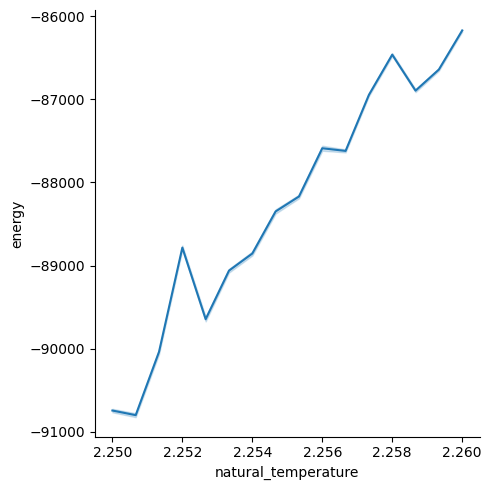

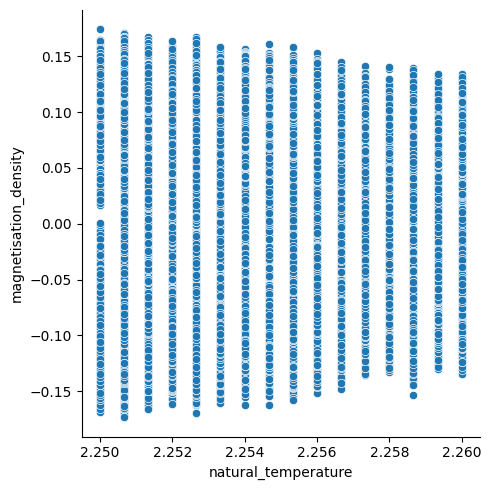

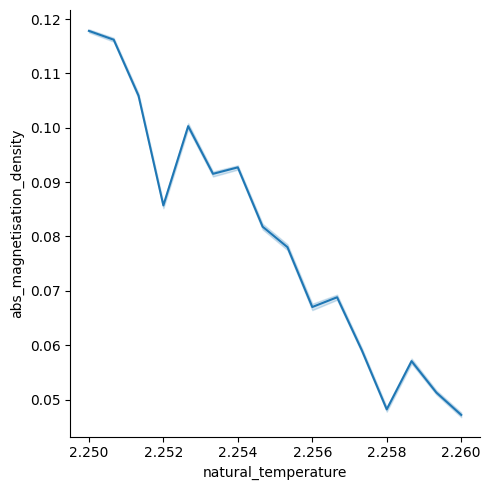

In [23]:
if c.do_measure:
    fig_measure_energy_temp = sns.relplot(
        data=meas_df,
        x="natural_temperature",
        y="energy",
        kind="line",
    )
    fig_measure_energy_temp.savefig(SAVE_PATH / "fig_measure_energy_temp.png")

    fig_measure_mag_dens_temp = sns.relplot(
        data=meas_df,
        x="natural_temperature",
        y="magnetisation_density",
        # kind="line",
    )
    fig_measure_mag_dens_temp.savefig(SAVE_PATH / "fig_measure_mag_dens_temp.png")

    fig_measure_abs_mag_dens_temp = sns.relplot(
        data=meas_df,
        x="natural_temperature",
        y="abs_magnetisation_density",
        kind="line",
    )
    fig_measure_abs_mag_dens_temp.savefig(
        SAVE_PATH / "fig_measure_abs_mag_dens_temp.png"
    )

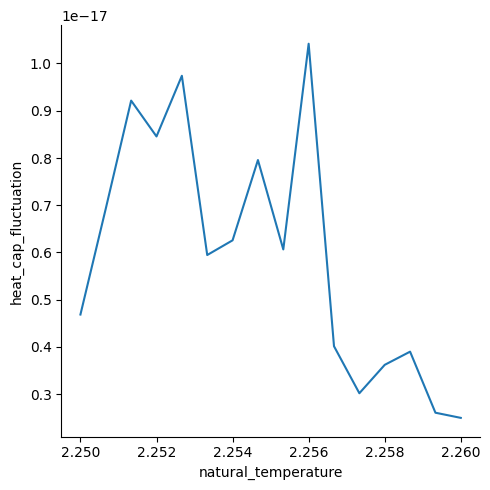

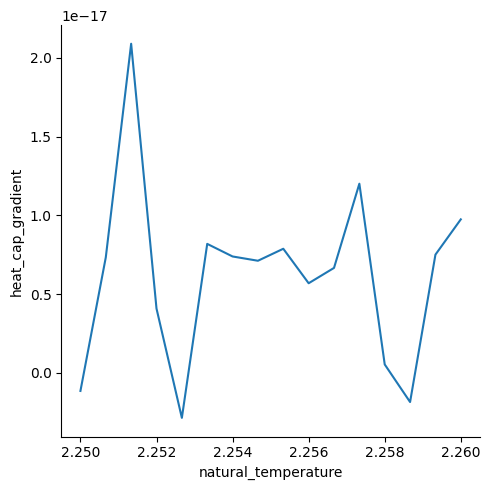

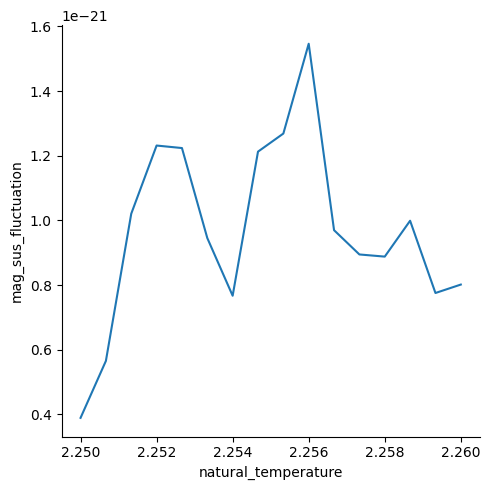

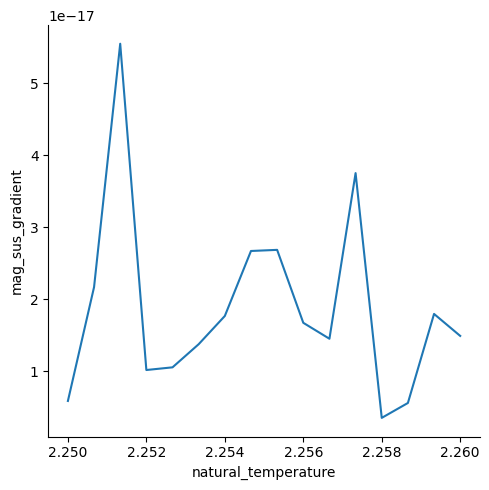

In [24]:
if c.do_measure:
    fig_measure_heat_cap_fluctuation_temp = sns.relplot(
        data=temp_df,
        x="natural_temperature",
        y="heat_cap_fluctuation",
        kind="line",
    )
    fig_measure_heat_cap_fluctuation_temp.savefig(
        SAVE_PATH / "fig_measure_heat_cap_fluctuation_temp.png"
    )

    fig_measure_heat_cap_gradient_temp = sns.relplot(
        data=temp_df,
        x="natural_temperature",
        y="heat_cap_gradient",
        kind="line",
    )
    fig_measure_heat_cap_gradient_temp.savefig(
        SAVE_PATH / "fig_measure_heat_cap_gradient_temp.png"
    )

    if not c.interaction_external_field:
        fig_measure_mag_sus_fluctuation_temp = sns.relplot(
            data=temp_df,
            x="natural_temperature",
            y="mag_sus_fluctuation",
            kind="line",
        )
        fig_measure_mag_sus_fluctuation_temp.savefig(
            SAVE_PATH / "fig_measure_mag_sus_fluctuation_temp.png"
        )

        fig_measure_mag_sus_gradient_temp = sns.relplot(
            data=temp_df,
            x="natural_temperature",
            y="mag_sus_gradient",
            kind="line",
        )
        fig_measure_mag_sus_gradient_temp.savefig(
            SAVE_PATH / "fig_measure_mag_sus_gradient_temp.png"
        )

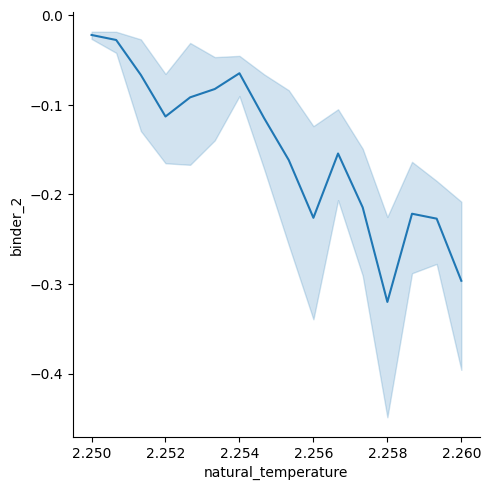

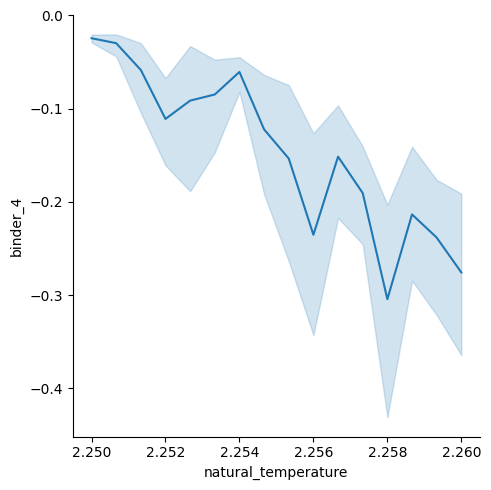

In [25]:
if c.do_measure:
    fig_measure_binder_2 = sns.relplot(
        data=sample_df,
        x="natural_temperature",
        y="binder_2",
        kind="line",
    )
    fig_measure_binder_2.savefig(SAVE_PATH / "fig_measure_binder_2.png")

    fig_measure_binder_4 = sns.relplot(
        data=sample_df,
        x="natural_temperature",
        y="binder_4",
        kind="line",
    )
    fig_measure_binder_4.savefig(SAVE_PATH / "fig_measure_binder_4.png")

In [26]:
with open(SAVE_PATH / "saved_variables.json", "w") as f:
    json.dump(
        to_save, f, indent=4, sort_keys=True, ensure_ascii=False, cls=NumpyEncoder
    )